# Pipeline for Question Answering -  ESG Assessment Projects BNP

### PARTIE CODE -------------------------------------------------------------------------------------------------

Loading all our nlp models ! (property of BNP Paribas Risk Air Team)

In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


TODO remaining: 
    - Traiter les espaces en trop du aux caracteres hexadécimaux dans les questions: Done
    - Traiter les espaces après dans les questions?: Done
    - Tester les modules et leur dépendences : Done
    - Ajouter token spécial pour chiffres: Done

In [27]:
%run pdf_reader/reader.ipynb
%run utils/generate_squad_examples.ipynb
%run nlp_models_retrievers/Bert.ipynb
%run nlp_models_retrievers/Infersent.ipynb
%run nlp_models_retrievers/Tf_Idf.ipynb
%run nlp_models_retrievers/Tf_Idf_Farahat_Bert.ipynb

In [4]:
import json
import os
import re
import sys
import uuid
import prettytable
import time
import cProfile
import re

import pandas as pd
import numpy as np
import tinyarray
import nltk
import torch

""" If you never installed punkt and wordnet:
nltk.download('punkt') 
nltk.download('wordnet')
!python -m textblob.download_corpora
"""
from tqdm import tqdm
from tika import parser
from nltk import tokenize as tkn
from string import digits
from nltk import pos_tag, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as skf
from sklearn.base import BaseEstimator
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from textblob import TextBlob
from models import InferSent
import enchant
from sentence_transformers import SentenceTransformer

from sklearn import decomposition
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import spherecluster
from sklearn import decomposition
from sklearn import datasets
pd.set_option('display.max_colwidth', 200)

/Users/williamlambert/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
import torch.nn as nn


class InferSent_(InferSent):

    def __init__(self, config):
        super(InferSent, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']
        self.version = 1 if 'version' not in config else config['version']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)

        assert self.version in [1, 2]
        if self.version == 1:
            self.bos = '<s>'
            self.eos = '</s>'
            self.max_pad = True
            self.moses_tok = False
        elif self.version == 2:
            self.bos = '<p>'
            self.eos = '</p>'
            self.max_pad = False
            self.moses_tok = True

    def is_cuda(self):
        # either all weights are on cpu or they are on gpu
        return self.enc_lstm.bias_hh_l0.data.is_cuda

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (bsize)
        # sent: (seqlen x bsize x worddim)
        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len_sorted, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent_len_sorted = sent_len_sorted.copy()
        idx_unsort = np.argsort(idx_sort)

        idx_sort = torch.from_numpy(idx_sort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_sort)
        sent = sent.index_select(1, idx_sort)

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len_sorted)
        sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]

        # Un-sort by length
        idx_unsort = torch.from_numpy(idx_unsort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_unsort)
        sent_output = sent_output.index_select(1, idx_unsort)

        # Pooling
        if self.pool_type == "mean":
            sent_len = torch.FloatTensor(sent_len.copy()).unsqueeze(1).cuda()
            emb = torch.sum(sent_output, 0).squeeze(0)
            emb = emb / sent_len.expand_as(emb)
        elif self.pool_type == "max":
            if not self.max_pad:
                sent_output[sent_output == 0] = -1e9
            emb = torch.max(sent_output, 0)[0]
            if emb.ndimension() == 3:
                emb = emb.squeeze(0)
                assert emb.ndimension() == 2

        return emb

    def set_w2v_path(self, w2v_path):
        self.w2v_path = w2v_path

    def get_word_dict(self, sentences, tokenize=True):
        # create vocab of words
        word_dict = {}
        sentences = [s.split() if not tokenize else self.tokenize(s) for s in sentences]
        for sent in sentences:
            for word in sent:
                if word not in word_dict:
                    word_dict[word] = ''
        word_dict[self.bos] = ''
        word_dict[self.eos] = ''
        return word_dict

    def get_w2v(self, word_dict):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with w2v vectors
        word_vec = {}
        with open(self.w2v_path) as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if word in word_dict:
                    word_vec[word] = np.fromstring(vec, sep=' ')
        print('Found %s(/%s) words with w2v vectors' % (len(word_vec), len(word_dict)))
        return word_vec

    def get_w2v_k(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with k first w2v vectors
        k = 0
        word_vec = {}
        with open(self.w2v_path) as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if k <= K:
                    word_vec[word] = np.fromstring(vec, sep=' ')
                    k += 1
                if k > K:
                    if word in [self.bos, self.eos]:
                        word_vec[word] = np.fromstring(vec, sep=' ')

                if k > K and all([w in word_vec for w in [self.bos, self.eos]]):
                    break
        return word_vec

    def build_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        word_dict = self.get_word_dict(sentences, tokenize)
        self.word_vec = self.get_w2v(word_dict)
        print('Vocab size : %s' % (len(self.word_vec)))

    # build w2v vocab with k most frequent words
    def build_vocab_k_words(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        self.word_vec = self.get_w2v_k(K)
        print('Vocab size : %s' % (K))

    def update_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'warning : w2v path not set'
        assert hasattr(self, 'word_vec'), 'build_vocab before updating it'
        word_dict = self.get_word_dict(sentences, tokenize)

        # keep only new words
        for word in self.word_vec:
            if word in word_dict:
                del word_dict[word]

        # udpate vocabulary
        if word_dict:
            new_word_vec = self.get_w2v(word_dict)
            self.word_vec.update(new_word_vec)
        else:
            new_word_vec = []
        print('New vocab size : %s (added %s words)'% (len(self.word_vec), len(new_word_vec)))

    def get_batch(self, batch):
        # sent in batch in decreasing order of lengths
        # batch: (bsize, max_len, word_dim)
        embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))

        for i in range(len(batch)):
            for j in range(len(batch[i])):
                embed[j, i, :] = self.word_vec[batch[i][j]]

        return torch.FloatTensor(embed)

    def tokenize(self, s):
        from nltk.tokenize import word_tokenize
        if self.moses_tok:
            s = ' '.join(word_tokenize(s))
            s = s.replace(" n't ", "n 't ")  # HACK to get ~MOSES tokenization
            return s.split()
        else:
            return word_tokenize(s)

    def prepare_samples(self, sentences, bsize, tokenize, verbose):
        sentences = [[self.bos] + s.split() + [self.eos] if not tokenize else
                     [self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
        n_w = np.sum([len(x) for x in sentences])

        # filters words without w2v vectors
        for i in range(len(sentences)):
            s_f = [word for word in sentences[i] if word in self.word_vec]
            if not s_f:
                import warnings
                warnings.warn('No words in "%s" (idx=%s) have w2v vectors. \
                               Replacing by "</s>"..' % (sentences[i], i))
                s_f = [self.eos]
            sentences[i] = s_f

        lengths = np.array([len(s) for s in sentences])
        n_wk = np.sum(lengths)
        if verbose:
            print('Nb words kept : %s/%s (%.1f%s)' % (
                        n_wk, n_w, 100.0 * n_wk / n_w, '%'))

        # sort by decreasing length
        lengths, idx_sort = np.sort(lengths)[::-1], np.argsort(-lengths)
        sentences = np.array(sentences)[idx_sort]

        return sentences, lengths, idx_sort

    def encode(self, sentences, bsize=64, tokenize=True, verbose=False):
        tic = time.time()
        sentences, lengths, idx_sort = self.prepare_samples(
                        sentences, bsize, tokenize, verbose)

        embeddings = []
        for stidx in range(0, len(sentences), bsize):
            batch = self.get_batch(sentences[stidx:stidx + bsize])
            if self.is_cuda():
                batch = batch.cuda()
            with torch.no_grad():
                batch = self.forward((batch, lengths[stidx:stidx + bsize])).data.cpu().numpy()
            embeddings.append(batch)
        embeddings = np.vstack(embeddings)

        # unsort
        idx_unsort = np.argsort(idx_sort)
        embeddings = embeddings[idx_unsort]

        if verbose:
            print('Speed : %.1f sentences/s (%s mode, bsize=%s)' % (
                    len(embeddings)/(time.time()-tic),
                    'gpu' if self.is_cuda() else 'cpu', bsize))
        return embeddings

    def visualize(self, sent, tokenize=True,display=False):

        sent = sent.split() if not tokenize else self.tokenize(sent)
        sent = [[self.bos] + [word for word in sent if word in self.word_vec] + [self.eos]]

        if ' '.join(sent[0]) == '%s %s' % (self.bos, self.eos):
            import warnings
            warnings.warn('No words in "%s" have w2v vectors. Replacing \
                           by "%s %s"..' % (sent, self.bos, self.eos))
        batch = self.get_batch(sent)

        if self.is_cuda():
            batch = batch.cuda()
        output = self.enc_lstm(batch)[0]
        output, idxs = torch.max(output, 0)
        # output, idxs = output.squeeze(), idxs.squeeze()
        idxs = idxs.data.cpu().numpy()
        argmaxs = [np.sum((idxs == k)) for k in range(len(sent[0]))]

        # visualize model
        
        
        x = range(len(sent[0]))
        y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
        if display:
            plt.xticks(x, sent[0], rotation=45)
            plt.bar(x, y)
            plt.ylabel('%')
            plt.title('Visualisation of words importance')
            plt.show()

        return output, idxs,y,sent[0]

### 1)  Pdf Retriever (using Tika & Enchant / np.vectorize for faster performance)

In [6]:
class pdfconverter():
    
    def __init__(self,directory_path='../question_answering/pdf_files/'):
        self.english_voc=enchant.Dict("en_US")
        self.text_processor_pdf=np.vectorize(self.text_preprocessing_pdf,otypes=[str])
        self.df = pd.DataFrame(columns=['pdf','directory','directory_index','raw paragraphs','paragraphs'])
        self.parser=[]
        self.parser_raw=[]
        self.directory_path=directory_path

        self.list_folder=[]
        self.paths={}
        for r,d,f in os.walk(self.directory_path):
            
            for folder in d:
                self.list_folder.append(folder)

        for folder in self.list_folder:
            for i,pdf in enumerate(os.listdir(os.path.join(self.directory_path,folder))):
                if pdf!= '.DS_Store':
                    self.paths[folder]=self.paths.get(folder,[])+[(i,pdf)]
        
    def transform(self):
        """Pdf-files reader with Apache Tika"""
        count=1
        for i,folder in enumerate(self.list_folder):
            path=os.path.join(self.directory_path,folder)
            for j,pdf in enumerate(os.listdir(path)):
                if pdf!= '.DS_Store':
                    self.df.loc[count] = [pdf,folder, i+1,None,None]
                    
                    """ 0- Read Pdf file """
                    raw = parser.from_file(os.path.join(path,pdf))
                    s = raw['content']
                    
                    """ 1- Handle linebreaks to optimize TextBlob.sentences results"""
                    s=self.treat_new_line(s)
                    
                    """ 2- Divide text by sentences using TextBlob"""
                    blob=TextBlob(s)
                    paragraphs = np.array([str(s) for s in blob.sentences],dtype=str)
                    self.parser = []
                    self.parser_raw=[]
                    p=self.text_processor_pdf(paragraphs)
                    
                    """
                    3- Get rid of bad text data:
                    Discard sentences with too long word (16 is the 99% quantile in english)
                    Discard sentences with too much upper words (CREDENTIALS, Link, TITLE ..)
                    """
                    index_=[i for i,c in enumerate(self.parser) if (True in [len(w)>=16 for w in c.split()] )]
                    index_raw=[i for i,c in enumerate(self.parser_raw) if np.sum([w==w.upper() for w in c.split()])>=4]
                    index=list(set(index_ + index_raw))
                    self.df.loc[count,'paragraphs']=np.delete(np.array(self.parser),index)
                    self.df.loc[count,'raw paragraphs']=np.delete(np.array(self.parser_raw),index)
                    count+=1
                            
                    print("{} succesfully converted ".format(pdf))
                
        """
        for i, pdf in enumerate(self.list_pdf):
            if pdf!= '.DS_Store':
                #try:
                self.df.loc[i] = [pdf, {None}]
                raw = parser.from_file(os.path.join(self.directory_path,pdf))
                s = raw['content']
                paragraphs = np.array(re.split(u'\n(?=\u2028|[A-Z-0-9])', s),dtype=str)
                self.parser = []
                p=self.text_processor_pdf(paragraphs)

                self.df.loc[i,'paragraphs']=self.parser
                        #df.loc[i, 'paragraphs'] = list_par
                print("{} succesfully converted ".format(pdf))
                #except:
                    #print("{} Error converting".format(pdf))
        """
        return self.df
    
    def remove_non_alpha(self,text):
        
        """ Remove non alpha-decimal caracters that are not dot or linebreaker """
        
        removelist="-\.\/"
        re_alpha_numeric1=r"[^0-9a-zA-Z"+removelist+" ]"
        clean_text=re.sub(re_alpha_numeric1,'',text)
        clean_text=clean_text.replace('/',' ')
        clean_text=re.sub(' +', ' ', clean_text)
        return clean_text
    
    def treat_new_line(self,text):
        """ 
        This function is aimed to deal with all types of linebreaks we met during our tests 
        There is linebreaks dure to cut-sentences, cut-words, bullet-list, title, new paragraphs, or sentences breaks
        """
        text=text.replace('.\n','. ')
        text=re.sub(r'(\n\s*)+\n+', '\n\n',text )
        
        lw=text.split('\n\n')
        lw=[c for c in lw if c.replace(' ','')!='']
            
        for i in range(1,len(lw)):
            try:

                el=lw[i]
                if len(el)>=1:
                    try:
                        first_w=el.split()[0]
                    except:
                        first_w=el
                    first_l=first_w[0]
                    if first_l.isupper() :
                        if len(lw[i-1])>0 and lw[i-1].replace(' ','') !='':
                            if lw[i-1].replace(' ','')[-1] not in [":",'.',"-",'/',"'",";"]:
                                prec=lw[i-1].split(".")[-1]
                                merge=(prec+' '+lw[i]).split()
                                dic=dict(nltk.tag.pos_tag(merge))
                                proper_noun=dic[first_w]=='NNP'
                                if not proper_noun:
                                    if not "." in lw[i-1]:
                                        lw[i-1]=lw[i-1]+".\n\n "
                                    else:
                                        lw[i-1]=lw[i-1][:-1]+".\n\n "
                                else:
                                    lw[i-1]+=' '


                    elif first_l.islower():
                        if len(lw[i-1])>0 and lw[i-1][-1].replace(' ','')!='':

                            if lw[i-1][-1].replace(' ','')[-1]!='-':
                                lw[i-1]+=""
                            else:

                                ltemp_prev=lw[i-1].split(' ')
                                ltemp_next=lw[i].split(' ')
                                motprev=ltemp_prev[-1][:-1]
                                motnext=lw[i].split(' ')[0]
                                if len((motprev+' '+motnext).split())==2:

                                    if self.english_voc.check(motprev) and self.english_voc.check(motnext) and not self.english_voc.check("".join([motprev,motnext])) :
                                        newmot=" ".join([motprev,motnext])
                                    else:
                                        newmot="".join([motprev,motnext])
                                    ltemp_prev[-1]=newmot
                                    ltemp_next[0]=""
                                    lw[i-1]=" ".join(ltemp_prev)
                                    lw[i]=" ".join(ltemp_next)
                    else:
                        lw[i-1]+="\n\n"
            
            except:
                print('Error occurs, the reader may not be suitable for your pdf files')
            
            
        text="".join(lw)
        
        lw=text.split('\n')
        lw=[c for c in lw if c.replace(' ','')!='']
        for i in range(1,len(lw)):
            try:
                el=lw[i]
                if len(el)>=1:
                    try:
                        first_w=el.split()[0]
                    except:
                        first_w=el
                    first_l=first_w[0]
                    if first_l.isupper() :
                        if len(lw[i-1])>0 and lw[i-1].replace(' ','')!='':
                            if lw[i-1].replace(' ','')[-1] not in [":",'.',"-",'/',"'",";"]:
                                prec=lw[i-1].split(".")[-1]
                                merge=(prec+' '+lw[i]).split()
                                dic=dict(nltk.tag.pos_tag(merge))
                                proper_noun=dic[first_w]=='NNP'
                                if not proper_noun:
                                    if not "." in lw[i-1]:
                                        lw[i-1]=lw[i-1]+".\n\n "
                                    else:
                                        lw[i-1]=lw[i-1][:-1]+".\n\n "
                                else:
                                    lw[i-1]+=' '
                    elif first_l.islower():
                        if len(lw[i-1])>0 and lw[i-1].replace(' ','')!='':
                            if lw[i-1].replace(' ','')[-1]=="-":
                                ltemp_prev=lw[i-1].split(' ')
                                ltemp_next=lw[i].split(' ')
                                motprev=ltemp_prev[-1][:-1]
                                motnext=lw[i].split(' ')[0]
                                if len((motprev+' '+motnext).split())==2:
                                    if self.english_voc.check(motprev) and self.english_voc.check(motnext) and not self.english_voc.check("".join([motprev,motnext])) :
                                        newmot=" ".join([motprev,motnext])
                                    else:
                                        newmot="".join([motprev,motnext])
                                    ltemp_prev[-1]=newmot
                                    ltemp_next[0]=""
                                    lw[i-1]=" ".join(ltemp_prev)
                                    lw[i]=" ".join(ltemp_next)



                            else:
                                lw[i-1]+=" "
                    else:
                        lw[i-1]+=" "
        
            except:
                print('Error occurs, the reader may not be suitable for your pdf files')
        
        text="".join(lw)
        return text
    
    """
    def remove_end_paragraphs(self,p):
        if '-\n' in p:
            paraph=[]
            ltemp=p.split(' ')
            for mot in ltemp:
                if '-\n' in mot:
                    if len(mot.replace('-\n',' ').split())==2:
                        mot1,mot2=mot.replace('-\n',' ').split()
                        if self.english_voc.check(mot1) and self.english_voc.check(mot2) and not self.english_voc.check("".join([mot1,mot2])) :
                            newmot=" ".join([mot1,mot2])
                        else:
                            newmot="".join([mot1,mot2])
                        paraph.append(newmot)
                else:
                    paraph.append(mot)
            p=" ".join(paraph)
        return p.replace('\n',' ')
    """
    
    def cut_text(self,p):
        """ Cut text into sentences """
        if len(p)>=100:
            phrases=self.remove_non_alpha(p)    
            phrases=phrases.replace('.',' ')
            phrases=phrases.replace('-',' ')
            phrases=re.sub(' +', ' ', phrases)
            phrases=re.sub(r'([0-9]+(?=[a-z])|(?<=[a-z])[0-9]+)',"",phrases)
            phrases=phrases.lower()
            self.parser.append(re.sub(' +', ' ', phrases))
            
        return None 
    
    def cut_text_raw(self,p):
        """Cut raw/untreated text into sentences """
        
        if len(self.remove_non_alpha(p))>=100:
            self.parser_raw.append(re.sub(' +', ' ', p))
            
        return None
    
    def text_preprocessing_pdf(self,p):
        """ Pipeline of sentences-preprocessing using np.vectorize for faster results """
        #remover_end_paragraphs=np.vectorize(self.remove_end_paragraphs,otypes=[str])
        cleaner=np.vectorize(self.remove_non_alpha,otypes=[str])
        cut_text=np.vectorize(self.cut_text,otypes=[str])
        cut_text_raw=np.vectorize(self.cut_text_raw,otypes=[str])
        cut_text_raw(p)
        p=cleaner(p)
        cut_text(p)
        return p


    
    



### 2) Tf Idf search ranking retriever with Porter-Stemming, Cosine Similarity and n-grams

In [7]:
pd.set_option('display.max_colwidth', 20000)

In [8]:
class TfidfRetriever(BaseEstimator):
    """
    A scikit-learn wrapper for TfidfRetriever. Trains a tf-idf matrix from a corpus
    of documents then finds the most N similar documents of a given input document by
    taking the dot product of the vectorized input document and the trained tf-idf matrix.
    
    Parameters
    ----------
    ngram_range : bool, optional
        [shape of ngram used to build vocab] (the default is False)
    max_df : bool, optional
        [while building vocab delete words that have a frequency>max_df] (the default is False)
    stop_words : str, optional
        ['english is the only value accepted'] (the default is False)
    paragraphs : iterable
        an iterable which yields either str, unicode or file objects
    top_n : int
        maximum number of top articles to retrieve
        header should be of format: title, paragraphs.
    verbose : bool, optional
        If true, all of the warnings related to data processing will be printed.
    Attributes
    ----------
    vectorizer : TfidfVectorizer
        See https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    tfidf_matrix : sparse matrix, [n_samples, n_features]
        Tf-idf-weighted document-term matrix.
        
    Examples
    --------
    >>> retriever = TfidfRetriever(ngram_range=(1, 2), max_df=0.85, stop_words='english')
    >>> retriever.fit(X=df['content'])
    
    >>> doc_index=int(input('Which document do you want to use for your question?'))
    >>> retriever.transform(X=df.loc[doc_index,'content'])
    
    >>> Q=str(input('Enter your question'))
    >>> Q=retriever.vectorizer.transform([Q])
    >>> closest_docs,scores = self.retriever.predict(newQst,df.loc[doc_index,'content'])
    """

    def __init__(self,
                 ngram_range=(1, 2),
                 max_df=0.85,
                 stop_words='english',
                 paragraphs=None,
                 verbose=False, top_n=5,
                lemmatize=True,
                transform_text=True):

        self.ngram_range = (1,1)
        self.max_df = max_df
        self.stop_words = stop_words
        self.paragraphs = paragraphs
        self.top_n = top_n
        self.verbose = verbose
        self.transform_text=transform_text
        self.lemmatize=lemmatize and self.transform_text
        self.stem=not lemmatize and self.transform_text
        if self.stem: self.stemmer=PorterStemmer()
        else: self.lemmatizer=WordNetLemmatizer() 
        self.stop_words_list=[self.tokenize(word)[0] for word in list(skf._check_stop_list('english'))]

    def stem_tokens(self,tokens, stemmer):
        stemmed = []
        for item in tokens:
            stemmed.append(stemmer.stem(item))
        return stemmed
    
    def lemmatize_tokens(self,tokens,lemmatizer):
        lemmas=[]
        for item in tokens:
            for word, tag in pos_tag(word_tokenize(item)):
                wntag = tag[0].lower()
                wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
                if not wntag:
                    lemma = word
                else:
                    lemma = lemmatizer.lemmatize(word, wntag)
            
            lemmas.append(lemma)
        return lemmas

        """
        for item in tokens:
            lemmas.append(lemmatizer.lemmatize(item))
        return lemmas
        """

    def tokenize(self,text):
        tokens = nltk.word_tokenize(text)
        if self.lemmatize:
        #stems = self.stem_tokens(tokens, self.stemmer)
            lemmas=self.lemmatize_tokens(tokens,self.lemmatizer)
            return lemmas
        elif self.stem:
            stems = self.stem_tokens(tokens, self.stemmer)
            return stems
        else:
            return tokens
        
        
    def fit(self, X, y=None): #generate features and return tfidf scores matrix 

        self.vectorizer = TfidfVectorizer(ngram_range=self.ngram_range,
                                          max_df=self.max_df,
                                   stop_words=self.stop_words_list,tokenizer=self.tokenize)
        self.vectorizer.fit(X)
        return self
    
    def transform(self,X,y=None):
        self.tfidf_matrix=self.vectorizer.transform(X)
        return self
    
    def predict(self, X, metadata):
        tfidf_matrix=self.tfidf_matrix[metadata[0]:metadata[1],:]
        #cherche les querries les plus proches de chaque sentence
        t0 = time.time()
        question_vector = self.vectorizer.transform([X])
        scores = pd.DataFrame(tfidf_matrix.dot(question_vector.T).toarray())
        closest_docs_indices = scores.sort_values(by=0, ascending=False).index[:self.top_n].values

        # inspired from https://github.com/facebookresearch/DrQA/blob/50d0e49bb77fe0c6e881efb4b6fe2e61d3f92509/scripts/reader/interactive.py#L63
        if self.verbose:
            rank = 1
            table = prettytable.PrettyTable(['rank', 'index', 'title'])
            for i in range(len(closest_docs_indices)):
                index = closest_docs_indices[i]
                if self.paragraphs:
                    article_index = self.paragraphs[int(index)]['index']
                    title = metadata.iloc[int(article_index)]['title']
                else:
                    title = metadata.iloc[int(index)]['title']
                table.add_row([rank, index, title])
                rank+=1
            print(table)
            print('Time: {} seconds'.format(round(time.time() - t0, 5)))

        return closest_docs_indices,scores

In [9]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
wnl = WordNetLemmatizer()
sent = 'I love potatoe cabbage holistic engineering and that is my life when I am paying attention'
for word, tag in pos_tag(word_tokenize(sent)):
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
        lemma = word
    else:
        lemma = wnl.lemmatize(word, wntag)
    print(lemma)


I
love
potatoe
cabbage
holistic
engineering
and
that
be
my
life
when
I
be
pay
attention


### Infersent search ranking retriever (used Tokenizing and Finetuning for our dataset + PCA to speed-up a bit )

In [10]:
class InfersentRetriever(BaseEstimator):
    """
    A scikit-learn estimator for TfidfRetriever. Trains a tf-idf matrix from a corpus
    of documents then finds the most N similar documents of a given input document by
    taking the dot product of the vectorized input document and the trained tf-idf matrix.
    
    Parameters
    ----------
    Ktop_words: int
        number of words used for sentence embeddings (the K most frequent english words - 
        for more information see Infersent repository.)
    paragraphs : iterable
        an iterable which yields either str, unicode or file objects
    top_n : int
        maximum number of top articles to retrieve
        header should be of format: title, paragraphs.
    verbose : bool, optional
        If true, all of the warnings related to data processing will be printed.
    Attributes
    """ 
    def __init__(self,
                 top_n=3,
                Ktop_words=500000,
                sentences=None,
                verbose=False,
                model_path=None, 
                w2v_path=None):
        self.top_n = top_n
        self.verbose = verbose
        self.Ktop_words=Ktop_words
        self.w2v_path=w2v_path
        self.model_path=model_path
        self.kwargs_Infersent = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                        'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
        
        self.infersent = InferSent_(self.kwargs_Infersent)
        self.infersent.load_state_dict(torch.load(self.model_path))
        self.infersent.set_w2v_path(self.w2v_path)
        self.infersent.build_vocab_k_words(K=self.Ktop_words)
        
    def fit(self,X,y=None):
        """ X: any iterable which contains words to finetune vocabulary """
        self.infersent.update_vocab(list([s for s in X ]))
        return self
    
    def transform(self,X,y=None):
        """ X: any iterable which contains sentences to embed """
        
        self.embeddings = self.infersent.encode(list([s for s in X ]),tokenize=True)
        self.embeddings=np.apply_along_axis(lambda v: self.normalize(v), 1,self.embeddings)
        self.pca = decomposition.PCA(n_components=900)
        self.pca.fit(self.embeddings)
        self.embeddings=self.pca.transform(self.embeddings)
        self.reduced_embeddings = np.apply_along_axis(lambda v: self.normalize(v), 1,self.embeddings)
        return self

    def normalize(self,array):
        return array/np.linalg.norm(array)
    
    def predict(self,X,metadata):

        reduced_embeddings=self.reduced_embeddings[metadata[0]:metadata[1],:]
        question=self.infersent.encode([X])
        encoded_question=self.normalize(question)
        transformed_question=self.pca.transform(encoded_question)
        self.reduced_question=self.normalize(transformed_question)
        
        self.data=reduced_embeddings.dot(self.reduced_question.T)
        self.scores_inf=pd.DataFrame(self.data,index=range(len(self.data)))
        self.closest_docs_indices = self.scores_inf.sort_values(by=0, ascending=False).index[:self.top_n].values
        
        return self.closest_docs_indices,self.scores_inf

In [11]:
class BertRetriever(BaseEstimator):
    def __init__(self,top_n=5):
        self.top_n = top_n
        self.bert=SentenceTransformer('bert-large-nli-stsb-mean-tokens')
    def fit(self,X,y=None):
        """ X: any iterable which contains words to finetune vocabulary """
        return self
    
    def transform(self,X,y=None):
        """ X: any iterable which contains sentences to embed """
        self.embeddings = self.bert.encode(list([s for s in X ]))
        self.reduced_embeddings = np.apply_along_axis(lambda v: self.normalize(v), 1,self.embeddings)
        return self
    
    def normalize(self,array):
        return array/np.linalg.norm(array)
    
    def predict(self,X,metadata):
        
        question=self.bert.encode([X])
        encoded_question=self.normalize(question)
        self.reduced_question=self.normalize(question)
        
        reduced_embeddings=self.reduced_embeddings[metadata[0]:metadata[1],:]
        
        data=reduced_embeddings.dot(self.reduced_question.T)
        self.scores_inf=pd.DataFrame(data,index=range(len(data)))
        closest_docs_indices = self.scores_inf.sort_values(by=0, ascending=False).index[:self.top_n].values
        return closest_docs_indices,self.scores_inf

        

In [12]:
class DistiLBertRetriever(BertRetriever):
    def __init__(self,top_n=3):
        super(BertRetriever, self).__init__()
        self.bert=SentenceTransformer('distilbert-base-uncased')
    def fit(self,X,y=None):
        """ X: any iterable which contains words to finetune vocabulary """
        return self
    
    def transform(self,X,y=None):
        """ X: any iterable which contains sentences to embed """
        self.embeddings = self.bert.encode(list([s for s in X ]))
        self.reduced_embeddings = np.apply_along_axis(lambda v: self.normalize(v), 1,self.embeddings)
        return self
    
    def normalize(self,array):
        return array/np.linalg.norm(array)
    
    def predict(self,X,metadata):

        question=self.bert.encode([X])
        encoded_question=self.normalize(question)
        self.reduced_question=self.normalize(question)
        
        reduced_embeddings=self.reduced_embeddings[metadata[0]:metadata[1],:]
        
        data=reduced_embeddings.dot(self.reduced_question.T)
        self.scores_inf=pd.DataFrame(data,index=range(len(data)))
        closest_docs_indices = self.scores_inf.sort_values(by=0, ascending=False).index[:self.top_n].values
        return closest_docs_indices,self.scores_inf

In [41]:
class Tfidf_FarahatCluster_Bert(BaseEstimator):
    """
    A scikit-learn estimator for TfidfRetriever. Trains a tf-idf matrix from a corpus
    of documents then finds the most N similar documents of a given input document by
    taking the dot product of the vectorized input document and the trained tf-idf matrix.
    
    Parameters
    ----------
    ngram_range : bool, optional
        [shape of ngram used to build vocab] (the default is False)
    max_df : bool, optional
        [while building vocab delete words that have a frequency>max_df] (the default is False)
    stop_words : str, optional
        ['english is the only value accepted'] (the default is False)
    paragraphs : iterable
        an iterable which yields either str, unicode or file objects
    top_n : int
        maximum number of top articles to retrieve
        header should be of format: title, paragraphs.
    verbose : bool, optional
        If true, all of the warnings related to data processing will be printed.
    Attributes
    ----------
    vectorizer : TfidfVectorizer
        See https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    tfidf_matrix : sparse matrix, [n_samples, n_features]
        Tf-idf-weighted document-term matrix.
        
    Examples
    --------
    >>> retriever = TfidfRetriever(ngram_range=(1, 2), max_df=0.85, stop_words='english')
    >>> retriever.fit(X=df['content'])
    
    >>> doc_index=int(input('Which document do you want to use for your question?'))
    >>> retriever.transform(X=df.loc[doc_index,'content'])
    
    >>> Q=str(input('Enter your question'))
    >>> Q=retriever.vectorizer.transform([Q])
    >>> closest_docs,scores = self.retriever.predict(newQst,df.loc[doc_index,'content'])
    """

    def __init__(self, TF_emb, q_emb, content, content_doc,stemmed_content, vocab, l_querries,l_querries_raw, by_querries=True, top_n=5,threshold_w=0.002, portion_w=1.0,rank=500,verbose=False):

        self.top_n = top_n
        self.verbose = verbose
        self.TF_emb=TF_emb
        self.threshold_importance=threshold_w
        self.prop_w=portion_w
        self.rk=rank
        self.by_querries=by_querries
        self.querries=l_querries.copy() #(dataframe querries with word importance)
        self.querries_raw=l_querries_raw.copy()
        self.content=content
        self.content_doc=content_doc
        self.stemmed_content=stemmed_content
        self.vocab=vocab
        self.dic_emb={}
        self.q_emb=q_emb
    
    def select_term_Naystrom(self,T):

        #T is the Tf-Idf Matrix 
        #s is the fraction of important words that we want to retrieve (s=1.0 generally)
        print('begin of term selection')
        #Retrieve all the stems of tf-idf vocabulary
        terms=self.vocab
        
        #First we remove digits of the terms candidate
        n=int(self.prop_w*len(terms))
        idx_words=[]
        for i,term in enumerate(terms):
            try: float(term)
            except: idx_words.append(i)

        #Secondly we set a threshold to select words that appear at least each p documents

        #Set threshold to select words that appear at least each p documents 
        self.freq_term=np.zeros((len(self.content),len(terms)))
        
        for j,stem in enumerate(self.stemmed_content):
            for i,c in enumerate(terms):
                if c in stem:
                    self.freq_term[j,i]+=1
                    
        self.freq_term_by_doc=np.apply_along_axis(lambda x: np.mean(x),0,self.freq_term)
        ids=np.where(self.freq_term_by_doc>self.threshold_importance )[0]
        idx_words=[ i for i in ids if i in idx_words]


        #Init selection of terms with most correlation 
        if self.prop_w!=1.0:
            prob=np.sum(np.abs(T)>0,axis=0)
            prob=prob/np.sum(prob)
            prob=np.squeeze(prob)
            idx=[]
            m=len(idx_words)

            for i in range(n):

                p=int(np.random.choice(m,1,prob[0]))
                idx.append(int(idx_words[p]))
                prob[idx_words[p]]=0
                prob=prob/np.sum(prob)

            return idx,np.squeeze(T[:,idx])
        
        else:
            idx=idx_words
            self.idx=idx
            return idx,np.squeeze(T[:,idx])
        print('end of term selection')
    
    

    def fit(self, X, y=None): 

        return self

    def transform(self): #generate new enhanced tf-idf-farahat features ( co-occurence weight frequency matrix) 
        
        idx,A=self.select_term_Naystrom(self.TF_emb.toarray())   
        
        #Full rank approximation
        if self.rk==-1:
            self.rk=len(idx)
                
        qemb=self.q_emb
        print('begin of creation kernel')
        
        X=self.TF_emb.toarray().transpose()
        X=np.c_[X,qemb]

        L=np.eye(X.shape[0])*np.sqrt(X.shape[0])
        L_inv=np.linalg.inv(L)
        G=L_inv@X@X.transpose()@L_inv
        Gs=G[idx,:]
        Gs=Gs[:,idx]
        S,V,D=np.linalg.svd(Gs, full_matrices=True)
        Ssub,Vsub=S[:,:self.rk], np.diag(V)[:self.rk,:self.rk]
        #Ssub,Vsub=S,np.diag(V)
        #G=Ssub@Vsub$Ssub.transpose() but this operation is not necessary, we just need the decomposition of G

        D_sub_inv=np.diag(np.apply_along_axis(lambda x: 1/np.sqrt(x) , 0, V[:self.rk]))
        #D_sub_inv=np.diag(np.apply_along_axis(lambda x: 1/np.sqrt(x) , 0, V))
        W=(((D_sub_inv@Ssub.transpose())@X[idx,:])@(X.transpose()))@X
        self.TF_FARAHAT_emb=np.apply_along_axis(lambda x: x/np.sqrt(np.sum(x**2)), 1,W.transpose())
        print('end of creation kernel')
        return self

    
    

    

    def predict(self,metadata,repo):
        print('begin Tf_farahat_predict')
        self.content_repo=self.content_doc[repo]
        questions=self.querries['query'].tolist()
        W_=self.TF_FARAHAT_emb
        print('begin scores compute and ranking')
        scores=W_[-len(questions):]@(W_[metadata[0]:metadata[1]].transpose())
        print('end scores compute')
        rank=np.apply_along_axis(lambda x:np.argsort(-x),1,scores)
        raw_or_treated=1 #raw text
        print('end scores ranking, scores.shape=',scores.shape)
        
        all_answers=[]
        all_scores=[]
        all_indices=[]
        all_models=[]
        all_ranks=[]
        all_querries=[]
        
        for question in range(len(questions)):
            cluster_ids=[]
            answers=[]
            answers_raw=[]
            dic_answers={}
            count_answers=1
            #print('*****  Question {} : {} {}'.format(question,questions[question],'********'))
            rk=0
            count=0
            #print('\n----------------\n')
            w_important=[w for w in questions[question].split(" ") if w==w.upper() ]
            #Display best candidates according to clustering
            
            ### Special words retrieval (Tf-Idf search) ###
            if w_important !=[]:
          
                for w in w_important:
                    ll=QAmodel.retriever.tokenize(w)
                    #print("w,ll=",w,ll)
                    if ll!=[]:
                        w=ll[0]
                        best_id=[i for i in range(rank.shape[1]) if w in self.content_repo[0][rank[question,i]].split(' ')]
                        if best_id!=[]:
                            id_match=best_id[0]
                            result=self.content_repo[raw_or_treated][rank[question,id_match]]
                            #print('Special Anserw : {}'.format(self.content_repo[raw_or_treated][rank[question,id_match]]))
                            #print('\n----------------\n')


                            all_indices.extend([rank[question,id_match]])
                            all_scores.extend([scores[question,rank[question,id_match]]])
                            all_answers.extend([result])
                            all_ranks.append(rk+1)
                            all_models.append("Tf-Idf- Semantic Kernel- Bert")
                            all_querries.append(self.querries_raw[question])
                            rk+=1
                            count_answers+=1
            
            ###Normal Loop Spherical Kmeans Clustering and Applying Bert encoder###
            #1 Get clusters
            print('begin loop cluster retriever')
            for answ in range(30):
                while True:
                    answer_raw=self.content_repo[raw_or_treated][rank[question,count]]
                    answer=self.content_repo[1-raw_or_treated][rank[question,count]]
                    dic_answers[answer]=dic_answers.get(answer,0)+1
                    if dic_answers[answer]==1:
                        break
                    cluster_ids.append(metadata[0]+rank[question,count])
                    count+=1
                
                answers.append(answer)
                answers_raw.append(answer_raw)

                #print('Anserw n°{} : {}'.format(count_answers,answer))
                #print('\n----------------\n')
                
            print('end loop cluster retriever')

            #2) Use Bert encoder inside clusters + cosine similarity retrieval
            Qst=questions[question].lower()
            newQst=pdfconverter().remove_non_alpha(Qst)
            newQst=newQst.replace('.','')

            print('initiate bert cluster retriever')
            bert=BertRetriever(top_n=5)
            
            #embeddings = bert.transform(list([s for s in answers ]))
            try:
                bert.embeddings = [QAmodel.bert.embeddings[i] for i in cluster_ids]
                bert.reduced_embeddings = np.apply_along_axis(lambda v: bert.normalize(v), 1,bert.embeddings)
            except:
                indices_saved=[i for (i,c) in enumerate(answers) if c in self.dic_emb.keys()]
                print('just saved {} bert encodings'.format(len(indices_saved)))
                indices_new=[i for i in range(len(answers)) if i not in indices_saved ]
                indices_sort=indices_saved+indices_new
                indices_unsort=np.argsort(indices_sort)
                saved_embeddings=np.array([self.dic_emb[answers[i]] for i in indices_saved])
                new_item=[answers[i] for i in indices_new]
                if indices_new!=[]:
                    bert.transform(list(new_item))
                    new_embeddings=bert.reduced_embeddings
                
                for (i,s) in enumerate(new_item):
                    print('shape1=',new_embeddings[i].shape)
                    self.dic_emb[s]=new_embeddings[i]
                    
                print('shape2=',saved_embeddings.shape,new_embeddings.shape)
                if indices_saved!=[]:
                    if indices_new==[]:
                        bert.reduced_embeddings=saved_embeddings
                    else:
                        bert.reduced_embeddings=np.r_[saved_embeddings,new_embeddings][indices_unsort]
                
                
                
            print('begin reranking prediction with bert class')
            indices,scores_bert=bert.predict(newQst,[0,len(answers)])
            scores_bert=scores_bert.loc[indices].values[:,0]
            text=[ answers_raw[i] for i in indices]
            print('end reranking prediction with bert class')
            for i,c in enumerate(text):
                
                #print('Anserws n° {} : {}'.format(i+1,c))
                #print('\n----------------\n')
                all_ranks.append(rk+1)
                all_models.append("Tf-Idf- Semantic Kernel- Bert")
                all_querries.append(self.querries_raw[question])
                rk+=1
               
            all_answers.extend(text)
            all_scores.extend(scores_bert)
            all_indices.extend(rank[question,:30][indices])
            #all_indices.extend(np.array(range(len(self.content_repo[0])))[rank[question,:self.top_n]])
            
        return pd.DataFrame(np.c_[all_querries,all_models,all_ranks,all_indices,all_answers, all_scores],columns=['Question','Model','Rank','Doc_index','Answer','Score'])
    
    

### 3) Unsupervised Question answering Pipeline (text ranking-retriever for a given querry)

In [42]:
class QApipeline():
    """
    ## kwargs :
    path_to_directory (str) : Directory to train language model tfidf
    ngram_range=(1,3) (tuple) : ngram range for tfidf words
    max_df=0.85 (float) : When building the vocabulary ignore terms that have a document frequency strictly 
                        ## higher than the given threshold (corpus-specific stop words). 
                        ## If float, the parameter represents a proportion of documents, integer absolute counts. 
                        ## This parameter is ignored if vocabulary is not None
    stop_words (str) : Language for tfidf (default 'english')
    paragraphs=None
    top=3 (int) : How many paragraphs to retrieve for querry matching (can be modified by threshold)
    verbose=False : print time of execution to build tfidf matrix and print errors
    MODEL_PATH = 'dataset/encoder/infersent2.pkl' 
    W2V_PATH = 'dataset/fastText/crawl-300d-2M.vec'  
    """
    
    def __init__(self,**kwargs):
        
        
        #new kwargs: 'threshold' (float between 0.5 and 1.0)
        
        self.kwargs_Tf_Idf = {key: value for key, value in kwargs.items()
                         if key in TfidfRetriever.__init__.__code__.co_varnames}

        self.kwargs_converter = {key: value for key, value in kwargs.items()
                            if key in pdfconverter.__init__.__code__.co_varnames}
        
        self.kwargs_Infersent={key: value for key, value in kwargs.items()
                         if key in InfersentRetriever.__init__.__code__.co_varnames}
        self.kwargs_Bert={key: value for key, value in kwargs.items()
                         if key in BertRetriever.__init__.__code__.co_varnames}
        self.kwargs_others={key: value for key, value in kwargs.items()
                            if ((key not in pdfconverter.__init__.__code__.co_varnames) and (key not in TfidfRetriever.__init__.__code__.co_varnames))}
        
        
        
        self.multisearch=kwargs['multisearch']
        self.TF_Idf_enhanced=kwargs['TfIdf_enhanced']
        self.threshold=kwargs['threshold']
        self.df=pdfconverter(**self.kwargs_converter).transform()
        self.l_questions=kwargs['l_questions']
        self.Qst_raw=self.l_questions.copy()
        self.sentences_chunk=kwargs['sentences_chunk']
        
        #Build vocabulary
        self.content =[] 
        self.voc=[]
        np.vectorize(lambda x: self.voc.extend(self.string_retriever(x.split())),otypes=[object])(np.array(self.content))
        self.voc=set(self.voc)
        
        #Extract all contents of repositories and index it 
        self.content=[]
        self.content_raw=[]
        self.contents_doc=[]
        self.borders=[0]
        for j,repo in enumerate(sorted(list(set(self.df.directory_index)))):
            dic_s=[{},{}]
            remove_idx=[[],[]]
            content_doc=[]
            content_doc_raw=[]
            title=self.df[self.df.directory_index==repo].directory.tolist()[0]
            self.df[self.df.directory_index==repo]['raw paragraphs'].apply(lambda x: self.update_dic(x,dic_s,0,remove_idx))
            self.df[self.df.directory_index==repo]['paragraphs'].apply(lambda x: self.update_dic(x,dic_s,1,remove_idx))
            self.df[self.df.directory_index==repo]['raw paragraphs'].apply(lambda x: content_doc_raw.extend(x))
            self.df[self.df.directory_index==repo]['paragraphs'].apply(lambda x: content_doc.extend(x))
            
            #Use treated text length to cap text size and raw_text size
            remove_idx=list(set(remove_idx[0]+remove_idx[1]))
            content_doc=np.delete(np.array(content_doc),remove_idx)
            content_doc_raw=np.delete(np.array(content_doc_raw),remove_idx)
            
            content=[content_doc[i] for i in range(len(content_doc)) if (len(content_doc[i])>=50 )]
            content_raw=[content_doc_raw[i] for i in range(len(content_doc)) if (len(content_doc[i])>=50)]
            self.borders.append(len(content))
            print("repo: {} , size={}".format(repo,len(content)))
            self.content.extend(list(content))
            self.content_raw.extend(list(content_raw))
            self.contents_doc.append([content,content_raw])
            
        self.borders=list(np.cumsum(self.borders))
        if self.sentences_chunk>1:

            self.content=[ ' '.join(x) for x in zip(self.content[0::2], self.content[1::2]) ]
            self.content_raw=[ ' '.join(x) for x in zip(self.content_raw[0::2], self.content_raw[1::2]) ]
            for i,(L1,L2) in enumerate(self.contents_doc):
                self.contents_doc[i][0]=[ ' '.join(x) for x in zip(L1[0::2], L1[1::2]) ]
                self.contents_doc[i][1]=[ ' '.join(x) for x in zip(L2[0::2], L2[1::2]) ]
            self.borders=[int(i/2) for i in self.borders]

        for i,c in enumerate(self.borders[:-1]):
            a=self.borders[i]
            content=self.contents_doc[i][0]
            content_raw=self.contents_doc[i][1]

            for z,s in enumerate(content):

                l=s.split(" ")
                for j,w in enumerate(l):
                    try:
                        float(w)
                        l[j]="XXX"
                    except:
                        l[j]=w
                try:
                    self.content[a+z]=" ".join(l)
                except:
                    print("error! ",a,z,self.borders,len(self.content))
                self.contents_doc[i][0][z]=" ".join(l)
                

            for z,s in enumerate(content_raw):
                l=s.split(" ")
                for j,w in enumerate(l):
                    try:
                        float(w)
                        l[j]="XXX"
                    except:
                        l[j]=w
                try:
                    self.content_raw[a+z]=" ".join(l)
                except:
                    print("error! ",a,z,self.borders,len(self.content))

                self.contents_doc[i][1][z]=" ".join(l)

                            
                        
                
                
                
            
        
        
    def update_dic(self,l,d,pos,r_index):
        for i,c in enumerate(l):
            
            d=d[pos].copy()
            d[c]=d.get(c,0)+1
            d[pos]=d
            if d[pos][c]>1:
                r_index[pos].append(i)
        return None
    
    def fit(self):
        
            #Fit Infersent-Glove
    
        #We need to init Infersent at least for the querry builder
        self.inferst = InfersentRetriever(**self.kwargs_Infersent)
            
        if self.multisearch:
            #Fit Infersent
            self.inferst.fit(self.content)
            self.inferst.transform(self.content)
            
            
            #Fit Bert pretrained
            self.bert=BertRetriever(**self.kwargs_Bert)
            self.bert.fit(self.content)#no finetuning for Bert
            self.bert.transform(self.content)
        
        #Fit Tf-Idf
        self.retriever = TfidfRetriever(**self.kwargs_Tf_Idf)
        self.retriever.fit(self.content)
        self.retriever.transform(self.content)
        
    
        #Initiate Tf-Idf enhanced
        if self.TF_Idf_enhanced:
            print("beginning of Tf_idf_farahat fit")
            TF=self.retriever.tfidf_matrix
            dataQu=self.generate_querries(self.l_questions)
            querries=dataQu['words_sort'].tolist()
            for i,q in enumerate(querries):
                q=' '.join(list(q))
                q=q.lower()
                q=pdfconverter().remove_non_alpha(q)
                q=q.replace('.','')
                querries[i]=q

            q_emb=self.retriever.vectorizer.transform(querries).toarray().transpose()
            content=self.content
            stemmed_content=[self.retriever.tokenize(s) for s in self.content]
            voc=self.retriever.vectorizer.get_feature_names()
            self.tf_idf_farahat=Tfidf_FarahatCluster_Bert(TF,q_emb,content,self.contents_doc.copy(),stemmed_content,voc,dataQu,self.Qst_raw)
            self.tf_idf_farahat.transform()
            print("end of Tf_idf_farahat fit")
        return self
    
    
        #Initialisation of Tf-Idf-Farahat
    
    def predict(self,Qst,VE_type='DP',VE_cdt='',range_chunks=(5,20)):
        """
        kwargs:
        ##VE_type: 'DP' for Detect Presence of 'VE' for Value extraction
        ##Qst: Querry
        ##VE_cdt : null
        ##range_chunks: (tuple object) lower and upper bounds for text length
        """
    
        #Ask for the repository to question
        df_show=self.df[['directory']].drop_duplicates(subset=['directory']).reset_index(drop=True)
        repo=int(input(('\n\n Choose a repository \n\n'+ '{}'+'\n\n').format(df_show.to_string())))
        
        min_,max_=range_chunks
        
        #Apply corpus transformations to querry for parcimony
        Qst=[q.lower() for q in self.Qst_raw]
        newQst=[ pdfconverter().remove_non_alpha(q) for q in Qst]
        newQst=[q.replace('.','') for q in newQst]
        
        self.Q_emb=self.retriever.vectorizer.transform(newQst)
        
        #Infersent and Bert Loop Retriever ------ (look for most similar sentence using Infersent / Bert embeddings )
        self.dataframe_infersent=[]
        self.dataframe_bert=[]
        self.dataframe_tf_farahat=[]
        try :
            self.multisearch==True
            print("deep neural networks in action..")
        except:
            print("fail")
        if self.multisearch :
            
            #Infersent ranking
            print("beginning of Infersent..")
            all_scores=[]
            all_models=[]
            all_querries=[]
            all_ranks=[]
            all_indices=[]
            all_answers=[]
            for i,qu in enumerate(newQst):
                
                indices,scores=self.inferst.predict(qu,[self.borders[repo],self.borders[repo+1]])
                p=len(indices)
                try :
                    bbb=indices[1]
                except:
                    print('Fail')
                all_scores.extend(scores.loc[indices].values[:,0])
                all_answers.extend([ self.contents_doc[repo][1][i] for i in indices])
                all_models.extend(['Infersent Bi-Lstm']*p)
                all_ranks.extend(list(range(1,p+1)))
                all_querries.extend([self.Qst_raw[i]]*p)
                all_indices.extend(indices)
            
            self.dataframe_infersent=pd.DataFrame(np.c_[all_querries,all_models,all_ranks,all_indices,all_answers,all_scores],columns=['Question','Model','Rank','Doc_index','Answer','Score'])
            try :
                series=self.dataframe_infersent.iloc[0]
            except:
                print("PROBLEM DATA INFERSENT:",all_scores,all_answers,all_models,all_ranks,all_querries,all_indices)
            print("Infersent ranking finished!")
                
        
            #Bert ranking
            print("beginning of bert..")
            all_scores=[]
            all_models=[]
            all_querries=[]
            all_ranks=[]
            all_indices=[]
            all_answers=[]
            for i,qu in enumerate(newQst):
                indices,scores=self.bert.predict(qu,[self.borders[repo],self.borders[repo+1]])
                p=len(indices)
                all_scores.extend(scores.loc[indices].values[:,0])
                all_answers.extend([ self.contents_doc[repo][1][i] for i in indices])
                all_models.extend(['Bert - transformer']*p)
                all_ranks.extend(list(range(1,p+1)))
                all_querries.extend([self.Qst_raw[i]]*p)
                all_indices.extend(indices)
            self.dataframe_bert=pd.DataFrame(np.c_[all_querries,all_models,all_ranks,all_indices,all_answers,all_scores],columns=['Question','Model','Rank','Doc_index','Answer','Score'])
            print("bert ranking finished !")
    
            
        #Tf-Idf Farahat Ranking
        
        if self.TF_Idf_enhanced :
            print('begin of Tf-idf Farahat ranking predict')
            self.dataframe_tf_farahat=self.tf_idf_farahat.predict([self.borders[repo],self.borders[repo+1]],repo)
            print("Tf-idf Farahat ranking finished!")
            
        
        #Tf-Idf Loop Retriever (look for a variable sized textchunk which match the querry using Tf-Idf)  ------
        print("beginning of Tf_idf_lemmatize..")
        all_scores=[]
        all_models=[]
        all_querries=[]
        all_ranks=[]
        all_indices=[]
        all_answers=[]
        
        dataQu=self.generate_querries(self.l_questions)
        querries=dataQu['words_sort'].tolist()
        for i,q in enumerate(querries):
            q=' '.join(list(q))
            q=q.lower()
            q=pdfconverter().remove_non_alpha(q)
            q=q.replace('.','')
            querries[i]=q

        for iq,qu in enumerate(newQst):
          
            closest_docs_indices,scores = self.retriever.predict(querries[iq],[self.borders[repo],self.borders[repo+1]])
            self.test=[self.contents_doc[repo][1][u] for u in closest_docs_indices]
            self.test2=[self.contents_doc[repo][0][u] for u in closest_docs_indices]
            selected_extract=[self.contents_doc[repo][0][u] for u in closest_docs_indices]
            selection=pd.DataFrame(selected_extract,index=closest_docs_indices,columns=['extract'])

            extract_chunks=[]
            scores_chunks=[]
            contexts=[]

            #Searching for optimal textchunk size that match the querry 
            for ind in selection.index:
                extract=selection.loc[ind,'extract']
                temp_scores=[]
                temp=[]

                for chunksize in range(min_,max_+1):
                    array=extract.split(' ')
                    if len(array)<chunksize and len(array)>min_:
                        temp.append(extract)
                        embed=self.retriever.vectorizer.transform([extract])
                        temp_scores.append(embed.dot(self.Q_emb[iq].T).toarray()[0,0])
                    else:
                        for j in range(len(array)):
                            if j+chunksize<=len(array)-1:
                                smallchunk=' '.join(array[j:j+chunksize]).lower()
                                embed=self.retriever.vectorizer.transform([smallchunk])
                                temp_scores.append(embed.dot(self.Q_emb[iq].T).toarray()[0,0])
                                temp.append(smallchunk)

                if temp_scores!=[]:
                    #print("temp_score=",temp_scores)
                    temp_scores=np.array(temp_scores)
                    pos,score=np.argmax(temp_scores),np.max(temp_scores)
                    scores_chunks.append(score)
                    extract_chunks.append(temp[pos])
                    contexts.append(ind)
            #print("scores_chunks=",scores_chunks)
            scores_chunks=np.array(scores_chunks)
            pos=(scores_chunks>self.threshold)
            scores_chunks=scores_chunks[pos]
            selected_indices=np.array(contexts)[pos]
            selected_extracts=np.array(extract_chunks)[pos]
            #selected_contexts=np.array(selection[selection.index==selected_indices]["extract"])
            selected_contexts=np.array(self.contents_doc[repo][1])[selected_indices]
            p=len(scores_chunks)
            
            all_models.extend(['Tf-Idf + Lemmatizer']*p)
            all_scores.extend(scores_chunks)
            all_querries.extend([self.Qst_raw[iq]]*p)
            idx_sort=np.argsort(-scores_chunks)
            all_ranks.extend((np.ones(p)+np.arange(p))[np.argsort(idx_sort)])
            all_indices.extend(selected_indices)
            all_answers.extend(selected_contexts)
            #print("mod,scores,querr,idx,rks,answ",len(all_models),len(all_scores),len(all_querries),len(all_indices),len(all_ranks),len(all_answers))
            
        #dataframe=pd.DataFrame(np.c_[selected_extracts,selected_contexts,selected_indices,scores_chunks],columns=['chunk','context','doc index','scores']).sort_values(by='scores',ascending=False)
        #['Question','Model','Rank','Doc_index','Answer','Score']
        self.dataframe=pd.DataFrame(np.c_[all_querries,all_models,all_ranks,all_indices,all_answers,all_scores],columns=['Question','Model','Rank','Doc_index','Answer','Score']).sort_values(by=['Question','Score'],ascending=False)
        print("Tf_idf_lemmatize ranking finished !")
        
        if VE_type=='DP':
            #return closest_passages_chunks[pos],scores_chunks[pos]
            return self.dataframe,self.dataframe_infersent,self.dataframe_bert,self.dataframe_tf_farahat
        
        if VE_type=='VE':
            JSON=generate_squad_examples(Qst,selected_indices,self.df_doc)
            return JSON

    def string_retriever(self,sentence_list):
        return [w  for w in sentence_list if not w.isdigit()]
    
    def generate_querries(self,querries):
        querries=[pdfconverter().remove_non_alpha(q) for q in querries]    
        sentences=[s[0].lower()+s[1:].replace('?','')  for s in querries]
        i=0
        important_words=[]
        unsorted_words=[]

        for qu in sentences:

            #Get scores from infersent visualization function (max-pooling et each layer)
            tensor,vector,scores,words=self.inferst.infersent.visualize(qu)
            scores=np.array(scores[1:len(scores)-1])
            words=np.array(words[1:len(words)-1])

            #Remove stopwords from querries and attributed scores
            pos=[i for i,c in enumerate(list(words)) if c not in self.retriever.stop_words_list]
            words=words[pos]
            scores=np.array(scores)[pos]
            scores=scores/np.sum(scores)

            #Sort query words by word importance keeping idx in memory to unsort it back
            data=pd.DataFrame(np.c_[words,scores],columns=['word','score'])
            idx=np.argsort(-np.array(data.score.values,dtype='float64'))
            idx_unsort=np.argsort(idx)
            data=data.sort_values(by=['score'],ascending=False)
            new_words=data.word.values
            new_scores=np.array(data.score.values,dtype=float)

            #Keeping a set of words that satisfy 70% of cumulative importance
            score_cum=np.cumsum(new_scores)
            pos=score_cum<0.75
            lw=new_words[pos]
            ls=new_scores[pos]
            lw_unsort=words[pos[idx]]

            important_words.append(lw)
            unsorted_words.append(lw_unsort)
            i+=1

        return pd.DataFrame(np.c_[querries, important_words,unsorted_words],columns=['query','words_sort','words_unsort'])

        
            
        

        

### Tests of retrievers and Comparison between Tf-Idf and Infersent GloVe and Bert

### Tf-Idf/ FastText or Glove / Bert

In [43]:
questions=['Does the company operate in countries out of the European Union?',
'Is at least one of the company’s production facilities classified as SEVESO « High » (European Detective) or equivalent in other countries',
'Is the Company involved in agricultural chemistry activities, including the production of nitrogenous potash and phosphate based fertilizers?',
'Has the company formalized a commitment (policy or program) to control and reduce pollution (water air and sol)?',
'Does the company have an emergency plan and a remediation plan to cope with the consequences of industrial accidents and to ensure business continuity?',
           'Does the company have an emergency plan and a remediation plan to cope with the consequences of industrial accidents?',
'Has the company formalized  a strategy to reduce its greenhouse gas  emissions?',
'Has the company implemented measures to reduce its greenhouse gas emissions, use of low-carbon energy sources and energy recovery and efficiency system?',
'Does the company monitor performance indicators to assess its progress compared to its climate related commitments?',
'Does the company monitor performance indicators to assess its progress with regard to energy consumption  per tons produced?',
'Does the company monitor performance indicators to assess its progress with regard to greenhouse gas emissions?',
'Does the company have a formalized commitment policy (policy or program) that addresses the safety of its plants or facilities (implementation of safety procedures and standards, installation of secondary containment, maintenance etc..)',
'Does the company monitor performance indicators with regard to health safety for aspects for workers relying on frequency or severity rates?',
'Is there a crisis management scheme to cope with an identified issue on product safety?']

In [44]:
args_Tf_Idf={'directory_path':'../question_answering/pdf_files/','w2v_path': 'dataset/GloVe/glove.840B.300d.txt', 'model_path': 'dataset/encoder/infersent2.pkl' ,'top_n':5,'threshold':0.00,'multisearch':False,'TfIdf_enhanced':False,'ngram_range':(1, 2),'lemmatize':False,'transform_text':True,'l_questions':questions,'sentences_chunk':1}
args_Infersent={'directory_path':'../question_answering/pdf_files/','w2v_path': 'dataset/fastText/crawl-300d-2M.vec', 'model_path': 'dataset/encoder/infersent2.pkl' ,'top_n':5,'threshold':0.00,'multisearch':True,'TfIdf_enhanced':True,'ngram_range':(1, 1),'lemmatize':True,'transform_text':True,'l_questions':questions,'sentences_chunk':1}
args_Tf_Idf_Farahat={'directory_path':'../question_answering/pdf_files/','w2v_path': 'dataset/fastText/crawl-300d-2M.vec', 'model_path': 'dataset/encoder/infersent2.pkl' ,'top_n':5,'threshold':0.00,'multisearch':False,'TfIdf_enhanced':True,'lemmatize':False,'ngram_range':(1, 1),'transform_text':True,'l_questions':questions,'sentences_chunk':1}
args_All_transforms={'directory_path':'../question_answering/pdf_files/','w2v_path': 'dataset/fastText/crawl-300d-2M.vec', 'model_path': 'dataset/encoder/infersent2.pkl' ,'top_n':5,'threshold':0.00,'multisearch':True,'TfIdf_enhanced':True,'lemmatize':False,'ngram_range':(1, 1),'transform_text':True,'l_questions':questions,'sentences_chunk':1}
args_FinalModel={'directory_path':'../question_answering/pdf_files/','w2v_path': 'dataset/fastText/crawl-300d-2M.vec', 'model_path': 'dataset/encoder/infersent2.pkl' ,'top_n':5,'threshold':0.00,'multisearch':False,'TfIdf_enhanced':True,'lemmatize':False,'ngram_range':(1, 1),'transform_text':True,'l_questions':questions,'sentences_chunk':1}


In [53]:
QAmodel=QApipeline(**args_All_transforms)
QAmodel.fit()

cdp-2018-climate-change-information-request-response.pdf succesfully converted 
q.pdf succesfully converted 
cdp-2018-water-information-request-response.pdf succesfully converted 
novartis-annual-report-2018-en.pdf succesfully converted 
repo: 1 , size=4869
Vocab size : 500000
Found 232(/683) words with w2v vectors
New vocab size : 500234 (added 232 words)


/Users/williamlambert/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'becau', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


beginning of Tf_idf_farahat fit
begin of term selection
begin of creation kernel
end of creation kernel
end of Tf_idf_farahat fit


Roche:

In [54]:
data1,data2,data3,data4=QAmodel.predict(questions, VE_type='DP',range_chunks=(8,35))



 Choose a repository 

  directory
0  Novartis

0
deep neural networks in action..
beginning of Infersent..
Infersent ranking finished!
beginning of bert..
bert ranking finished !
begin of Tf-idf Farahat ranking predict
begin Tf_farahat_predict
begin scores compute and ranking
end scores compute
end scores ranking, scores.shape= (14, 4869)
begin loop cluster retriever
end loop cluster retriever
initiate bert cluster retriever
begin reranking prediction with bert class
end reranking prediction with bert class
begin loop cluster retriever
end loop cluster retriever
initiate bert cluster retriever
begin reranking prediction with bert class
end reranking prediction with bert class
begin loop cluster retriever
end loop cluster retriever
initiate bert cluster retriever
begin reranking prediction with bert class
end reranking prediction with bert class
begin loop cluster retriever
end loop cluster retriever
initiate bert cluster retriever
begin reranking prediction with bert class
end reran

In [107]:
data1

,Question,Model,Rank,Doc_index,Answer,Score
67,Is there a crisis management scheme to cope with an identified issue on product safety?,Tf-Idf + Lemmatizer,1.0,1001,"As part of our comprehensive Compliance Management System, we have adopted a policy on safety, security, health and environment of our employees.",0.236880133650043
65,Is there a crisis management scheme to cope with an identified issue on product safety?,Tf-Idf + Lemmatizer,2.0,1008,"On a global level, we are systematically identifying human rights and identify vulnerable groups, which could be negatively impacted by our businesses.",0.20524048022241717
66,Is there a crisis management scheme to cope with an identified issue on product safety?,Tf-Idf + Lemmatizer,3.0,1390,We are all encouraged to identify areas for improvements and continuously work towards a better environment.,0.15551753454349201
68,Is there a crisis management scheme to cope with an identified issue on product safety?,Tf-Idf + Lemmatizer,4.0,1331,"Being active in clinical and genetic research, Roche must ensure that identifiable health information is carefully processed.",0.15210973009495576
69,Is there a crisis management scheme to cope with an identified issue on product safety?,Tf-Idf + Lemmatizer,5.0,710,"We identified human rights which are potentially susceptible to violations, as well as their associated risks.",0.10852181013467649
11,"Is the Company involved in agricultural chemistry activities, including the production of nitrogenous potash and phosphate based fertilizers?",Tf-Idf + Lemmatizer,1.0,1460,misleading and suggestive statements may trigger an investigation against Roche as a company as well as against the employee involved.,0.22415137867296625
14,"Is the Company involved in agricultural chemistry activities, including the production of nitrogenous potash and phosphate based fertilizers?",Tf-Idf + Lemmatizer,2.0,398,"By the end of 2018, XXX pharmaceutical companies and associations were involved in this programme, in which partners such as the World Bank Group and the Union for International Cancer Control (UICC) participate.",0.18608275289688142
10,"Is the Company involved in agricultural chemistry activities, including the production of nitrogenous potash and phosphate based fertilizers?",Tf-Idf + Lemmatizer,3.0,530,"Apprentices can gain valuable experience in XXX professions, including informatics, biology, chemistry, automation and electronics.",0.1647406882130872
13,"Is the Company involved in agricultural chemistry activities, including the production of nitrogenous potash and phosphate based fertilizers?",Tf-Idf + Lemmatizer,4.0,980,"In addition, businesses are expected to become pro-active and make an active contribution to improve the situation, before the implementation of legal frameworks and beyond their legal boundaries.",0.14135675343842524
12,"Is the Company involved in agricultural chemistry activities, including the production of nitrogenous potash and phosphate based fertilizers?",Tf-Idf + Lemmatizer,5.0,771,Capital structure Business activities are carried out through Group subsidiaries and associated companies.,0.10965299618531675


In [55]:
list_questions_results=data2.Question.unique().tolist()
dic_questions={}
for i,s in enumerate(list_questions_results):
    dic_questions[s]=i+1

In [60]:
frames_Novartis=[data1,data2,data3,data4]
result_Novartis = pd.concat(frames_Novartis)
result_Novartis['Rank']=result_Novartis['Rank'].map(lambda x: x[0])
result_Novartis['Q_id']=result_Novartis.apply(lambda x: dic_questions[x.Question],axis=1)
result_Novartis['Company']=['Novartis']*len(result_Novartis)
results_Novartis=result_Novartis.sort_values(by=['Q_id','Company','Model','Rank']).reset_index(drop=True)[['Question','Q_id','Company','Model','Answer','Rank','Score','Doc_index']]


In [61]:
results_Novartis

,Question,Q_id,Company,Model,Answer,Rank,Score,Doc_index
0,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,Patents Patent applications in Europe may be filed in the European Patent Office (EPO) or in a particular country in Europe.,1,0.57026166,2499
1,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"In addition, prices for marketed products are referenced within member states and across member state borders, further impacting individual EU member state pricing.",2,0.5109576,2459
2,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"In the EU, decisions on the granting of a marketing authorization are made either by the European Commission based on a positive recommendation by the EMA under the centralized procedure, or by a single member state under the national or decentralized procedure.",3,0.48538196,2637
3,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"These impacts are being felt through EU ETS in Europe for a pricing scheme, and the other impacts may occur in multiple markets.",4,0.48038045,226
4,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"In addition, the European Commission continues to extend the application of its policies seeking to limit fiscal aid by member states to particular companies, and the related investigation of the member states’ practices regarding the issuance of rulings on tax matters relating to individual companies.",5,0.480069,1928
5,Does the company operate in countries out of the European Union?,1,Novartis,Infersent Bi-Lstm,"Galvus and Eucreas are co-marketed by Merck KGaA as Jalra and Jalra M, respectively, in some countries in Latin America.",1,0.4667485,2227
6,Does the company operate in countries out of the European Union?,1,Novartis,Infersent Bi-Lstm,"For example, the first Entresto local brand was launched within XXX months of the launch in the European Union.",2,0.4663378,2130
7,Does the company operate in countries out of the European Union?,1,Novartis,Infersent Bi-Lstm,"The principal markets for our Alcon Division include North America, Latin America, Japan, Asia and Europe.",3,0.4505594,2683
8,Does the company operate in countries out of the European Union?,1,Novartis,Infersent Bi-Lstm,Our multinational operations are taxed under the laws of the countries and other jurisdictions in which we operate.,4,0.42783558,1920
9,Does the company operate in countries out of the European Union?,1,Novartis,Infersent Bi-Lstm,Our multinational operations are taxed under the laws of the countries and other jurisdictions in which we operate.,5,0.42783558,3103


Pfizer:

In [22]:
data1,data2,data3,data4=QAmodel.predict(questions, VE_type='DP',range_chunks=(8,35))



 Choose a repository 

  directory
0     Roche
1   Johnson
2    Pfizer

1
deep neural networks in action..
beginning of Infersent..
Infersent ranking finished!
beginning of bert..
bert ranking finished !
begin of Tf-idf Farahat ranking predict
Tf-idf Farahat ranking finished!
beginning of Tf_idf_lemmatize..
Tf_idf_lemmatize ranking finished !


In [112]:
list_questions_results=data2.Question.unique().tolist()
dic_questions={}
for i,s in enumerate(list_questions_results):
    dic_questions[s]=i+1

In [23]:
frames_Johnson=[data1,data2,data3,data4]
result_Johnson= pd.concat(frames_Johnson)
result_Johnson['Rank']=result_Johnson['Rank'].map(lambda x: x[0])
result_Johnson['Q_id']=result_Johnson.apply(lambda x: dic_questions[x.Question],axis=1)
result_Johnson['Company']=['Johnson']*len(result_Johnson)
results_Johnson=result_Johnson.sort_values(by=['Q_id','Company','Model','Rank']).reset_index(drop=True)[['Question','Q_id','Company','Model','Answer','Rank','Score','Doc_index']]

Johnson

In [24]:
data1,data2,data3,data4=QAmodel.predict(questions, VE_type='DP',range_chunks=(8,35))



 Choose a repository 

  directory
0     Roche
1   Johnson
2    Pfizer

2
deep neural networks in action..
beginning of Infersent..
Infersent ranking finished!
beginning of bert..
bert ranking finished !
begin of Tf-idf Farahat ranking predict
Tf-idf Farahat ranking finished!
beginning of Tf_idf_lemmatize..
Tf_idf_lemmatize ranking finished !


In [25]:
frames_Pfizer=[data1,data2,data3,data4]
result_Pfizer= pd.concat(frames_Pfizer)
result_Pfizer['Rank']=result_Pfizer['Rank'].map(lambda x: x[0])
result_Pfizer['Q_id']=result_Pfizer.apply(lambda x: dic_questions[x.Question],axis=1)
result_Pfizer['Company']=['Pfizer']*len(result_Pfizer)
results_Pfizer=result_Pfizer.sort_values(by=['Q_id','Company','Model','Rank']).reset_index(drop=True)[['Question','Q_id','Company','Model','Answer','Rank','Score','Doc_index']]

Pfizer

All

In [73]:

results_Novartis=results_PfizerRocheJohnson.sort_values(by=['Q_id','Company','Model','Rank']).reset_index(drop=True)[['Question','Q_id','Company','Model','Answer','Rank','Score','Doc_index']]
results_Novartis.to_csv('Results_PfizerRocheJohnson.csv')

In [75]:
results_PfizerRocheJohnson

,Question,Q_id,Company,Model,Answer,Rank,Score,Doc_index,Context_Answer
0,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"During 2016, the Company divestitures included: the controlled substance raw material and active pharmaceutical ingredient (API) business; certain anesthetic products in Europe; and certain non-strategic Consumer brands.",1,0.46158153,2329,"During 2017, the Company divestitures primarily included: the Codman Neurosurgery business, to Integra LifeSciences. During 2016, the Company divestitures included: the controlled substance raw material and active pharmaceutical ingredient (API) business; certain anesthetic products in Europe; and certain non-strategic Consumer brands. Legal Proceedings Johnson & Johnson and certain of its subsidiaries are involved in various lawsuits and claims regarding product liability, intellectual property, commercial, supplier indemnification and other matters; governmental investigations; and other legal proceedings that arise from time to time in the ordinary course of their business."
1,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"The Enterprise Governance Council (EGC), a global, cross functional team of senior leaders representing functional groups and business segments, oversees this work.",2,0.39178875,993,"We also reviewed and updated our governance structure for managing human rights across our value chain. The Enterprise Governance Council (EGC), a global, cross functional team of senior leaders representing functional groups and business segments, oversees this work. Quarterly EGC meetings provide a forum for updates on human rights topics, with an established process for elevating issues to the Johnson & Johnson Executive Committee, our Board of Directors and Board Committees if warranted."
2,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"Clinical trials conducted around the world by our pharmaceutical, medical devices and consumer product companies are listed on the U.S. National Institutes of Health’s website, www.clinicaltrials.gov, the European Clinical Trial Register, and country-specific and regional registries across the globe.",3,0.38455927,954,"• Clinical Data Transparency: We support the overall principles of greater clinical trial data transparency, including registration and disclosure of clinical trial results in external registries; publication of results in peer-reviewed journals; and sharing of clinical study reports and participant-level data from clinical trials. Clinical trials conducted around the world by our pharmaceutical, medical devices and consumer product companies are listed on the U.S. National Institutes of Health’s website, www.clinicaltrials.gov, the European Clinical Trial Register, and country-specific and regional registries across the globe. • Political Engagement: As a global healthcare company, we work with many stakeholders in the markets where we operate, and we take a stance on and support certain public policies in the United States and in different parts of the world as they relate to our core business of advancing health."
3,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,The Company operates in certain countries where the economic conditions continue to present significant challenges.,4,0.38348675,1925,"In response to these concerns, the Company has a long-standing policy of pricing products responsibly. The Company operates in certain countries where the economic conditions continue to present significant challenges. Inflation rates continue to have an effect on worldwide economies and, consequently, on the way companies operate."
4,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,The products sold in international business include those developed in the U.S. and by subsidiaries abroad.,5,0.3

In [77]:
results_PfizerRocheJohnson.to_csv('Results_PfizerRocheJohnson.csv')

,Question,Q_id,Company,Model,Answer,Rank,Score,Doc_index,Context_Answer
0,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"During 2016, the Company divestitures included: the controlled substance raw material and active pharmaceutical ingredient (API) business; certain anesthetic products in Europe; and certain non-strategic Consumer brands.",1,0.46158153,2329,"During 2017, the Company divestitures primarily included: the Codman Neurosurgery business, to Integra LifeSciences. During 2016, the Company divestitures included: the controlled substance raw material and active pharmaceutical ingredient (API) business; certain anesthetic products in Europe; and certain non-strategic Consumer brands. Legal Proceedings Johnson & Johnson and certain of its subsidiaries are involved in various lawsuits and claims regarding product liability, intellectual property, commercial, supplier indemnification and other matters; governmental investigations; and other legal proceedings that arise from time to time in the ordinary course of their business."
1,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"The Enterprise Governance Council (EGC), a global, cross functional team of senior leaders representing functional groups and business segments, oversees this work.",2,0.39178875,993,"We also reviewed and updated our governance structure for managing human rights across our value chain. The Enterprise Governance Council (EGC), a global, cross functional team of senior leaders representing functional groups and business segments, oversees this work. Quarterly EGC meetings provide a forum for updates on human rights topics, with an established process for elevating issues to the Johnson & Johnson Executive Committee, our Board of Directors and Board Committees if warranted."
2,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"Clinical trials conducted around the world by our pharmaceutical, medical devices and consumer product companies are listed on the U.S. National Institutes of Health’s website, www.clinicaltrials.gov, the European Clinical Trial Register, and country-specific and regional registries across the globe.",3,0.38455927,954,"• Clinical Data Transparency: We support the overall principles of greater clinical trial data transparency, including registration and disclosure of clinical trial results in external registries; publication of results in peer-reviewed journals; and sharing of clinical study reports and participant-level data from clinical trials. Clinical trials conducted around the world by our pharmaceutical, medical devices and consumer product companies are listed on the U.S. National Institutes of Health’s website, www.clinicaltrials.gov, the European Clinical Trial Register, and country-specific and regional registries across the globe. • Political Engagement: As a global healthcare company, we work with many stakeholders in the markets where we operate, and we take a stance on and support certain public policies in the United States and in different parts of the world as they relate to our core business of advancing health."
3,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,The Company operates in certain countries where the economic conditions continue to present significant challenges.,4,0.38348675,1925,"In response to these concerns, the Company has a long-standing policy of pricing products responsibly. The Company operates in certain countries where the economic conditions continue to present significant challenges. Inflation rates continue to have an effect on worldwide economies and, consequently, on the way companies operate."
4,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,The products sold in international business include those developed in the U.S. and by subsidiaries abroad.,5,0.3

In [82]:
results_Novartis

,Question,Q_id,Company,Model,Answer,Rank,Score,Doc_index,Context_Answer
0,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,Patents Patent applications in Europe may be filed in the European Patent Office (EPO) or in a particular country in Europe.,1,0.57026166,2499,"• The FDA may also request that a sponsor conduct pediatric studies, and in exchange, it will grant an additional six-month period of pediatric market exclusivity if the FDA accepts the data, the sponsor makes a timely application for approval for pediatric treatment, and the sponsor has either a patent-based or regulatory-based exclusivity period for the product that can be extended. Patents Patent applications in Europe may be filed in the European Patent Office (EPO) or in a particular country in Europe. The EPO system permits a single application to be granted for the EU plus other non-EU countries such as Switzerland and Turkey."
1,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"In addition, prices for marketed products are referenced within member states and across member state borders, further impacting individual EU member state pricing.",2,0.5109576,2459,"Increasingly strict analyses are applied when evaluating the entry of new products, and as a result, access to innovative medicines is limited based on strict cost-benefit assessments. In addition, prices for marketed products are referenced within member states and across member state borders, further impacting individual EU member state pricing. As an additional control for healthcare budgets, some EU countries have passed legislation to impose further mandatory rebates for pharmaceutical products and/or financial claw-backs on the pharmaceutical industry."
2,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"In the EU, decisions on the granting of a marketing authorization are made either by the European Commission based on a positive recommendation by the EMA under the centralized procedure, or by a single member state under the national or decentralized procedure.",3,0.48538196,2637,"However, generic applicants must launch their products within certain timeframes or risk losing the marketing exclusivity that they had gained by being a first-to-file applicant. In the EU, decisions on the granting of a marketing authorization are made either by the European Commission based on a positive recommendation by the EMA under the centralized procedure, or by a single member state under the national or decentralized procedure. Companies may submit Abridged Applications for approval of a generic medicinal product based upon its “essential similarity” to a medicinal product authorized and marketed in the EU following the expiration of the product’s data exclusivity period."
3,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"These impacts are being felt through EU ETS in Europe for a pricing scheme, and the other impacts may occur in multiple markets.",4,0.48038045,226,"Threats to the business include rising costs due to carbon pricing frameworks designed to achieve climate mitigation, risks to reputation if we don't behave as a responsible corporate citizen, loss of biodiversity that will disrupt our supply chain and the physical impacts from climate change that will introduce risk into our sites, the communities we serve and our patients. These impacts are being felt through EU ETS in Europe for a pricing scheme, and the other impacts may occur in multiple markets. Increased costs could impact the bottom line and reduce funding for research and development of new drugs."
4,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"In addition, the European Commission continues to extend the application of its policies seeking to limit fiscal aid by member states to particular companies, and t

In [81]:
results_Novartis.to_csv('Results_Novartis.csv')

In [52]:
results_PfizerRocheJohnson

,Question,Q_id,Company,Model,Answer,Rank,Score,Doc_index,Context_Answer
0,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"During 2016, the Company divestitures included: the controlled substance raw material and active pharmaceutical ingredient (API) business; certain anesthetic products in Europe; and certain non-strategic Consumer brands.",1,0.46158153,2329,"During 2017, the Company divestitures primarily included: the Codman Neurosurgery business, to Integra LifeSciences. During 2016, the Company divestitures included: the controlled substance raw material and active pharmaceutical ingredient (API) business; certain anesthetic products in Europe; and certain non-strategic Consumer brands. Legal Proceedings Johnson & Johnson and certain of its subsidiaries are involved in various lawsuits and claims regarding product liability, intellectual property, commercial, supplier indemnification and other matters; governmental investigations; and other legal proceedings that arise from time to time in the ordinary course of their business."
1,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"The Enterprise Governance Council (EGC), a global, cross functional team of senior leaders representing functional groups and business segments, oversees this work.",2,0.39178875,993,"We also reviewed and updated our governance structure for managing human rights across our value chain. The Enterprise Governance Council (EGC), a global, cross functional team of senior leaders representing functional groups and business segments, oversees this work. Quarterly EGC meetings provide a forum for updates on human rights topics, with an established process for elevating issues to the Johnson & Johnson Executive Committee, our Board of Directors and Board Committees if warranted."
2,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"Clinical trials conducted around the world by our pharmaceutical, medical devices and consumer product companies are listed on the U.S. National Institutes of Health’s website, www.clinicaltrials.gov, the European Clinical Trial Register, and country-specific and regional registries across the globe.",3,0.38455927,954,"• Clinical Data Transparency: We support the overall principles of greater clinical trial data transparency, including registration and disclosure of clinical trial results in external registries; publication of results in peer-reviewed journals; and sharing of clinical study reports and participant-level data from clinical trials. Clinical trials conducted around the world by our pharmaceutical, medical devices and consumer product companies are listed on the U.S. National Institutes of Health’s website, www.clinicaltrials.gov, the European Clinical Trial Register, and country-specific and regional registries across the globe. • Political Engagement: As a global healthcare company, we work with many stakeholders in the markets where we operate, and we take a stance on and support certain public policies in the United States and in different parts of the world as they relate to our core business of advancing health."
3,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,The Company operates in certain countries where the economic conditions continue to present significant challenges.,4,0.38348675,1925,"In response to these concerns, the Company has a long-standing policy of pricing products responsibly. The Company operates in certain countries where the economic conditions continue to present significant challenges. Inflation rates continue to have an effect on worldwide economies and, consequently, on the way companies operate."
4,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,The products sold in international business include those developed in the U.S. and by subsidiaries abroad.,5,0.3

In [58]:
def func_add_context(row):
    if row.Company=='Pfizer':
        row['Context_Answer']=' '.join([QAmodel.contents_doc[2][1][int(row.Doc_index)-1],row.Answer,QAmodel.contents_doc[2][1][int(row.Doc_index)+1]])
    elif row.Company=='Johnson':
        row['Context_Answer']=' '.join([QAmodel.contents_doc[1][1][int(row.Doc_index)-1],row.Answer,QAmodel.contents_doc[1][1][int(row.Doc_index)+1]])
    else:
        row['Context_Answer']=' '.join([QAmodel.contents_doc[0][1][int(row.Doc_index)-1],row.Answer,QAmodel.contents_doc[0][1][int(row.Doc_index)+1]])
    return row


In [79]:
results_Novartis=results_Novartis.apply(func_add_context,axis=1)

In [80]:
results_Novartis.to_csv('')

,Question,Q_id,Company,Model,Answer,Rank,Score,Doc_index,Context_Answer
0,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,Patents Patent applications in Europe may be filed in the European Patent Office (EPO) or in a particular country in Europe.,1,0.57026166,2499,"• The FDA may also request that a sponsor conduct pediatric studies, and in exchange, it will grant an additional six-month period of pediatric market exclusivity if the FDA accepts the data, the sponsor makes a timely application for approval for pediatric treatment, and the sponsor has either a patent-based or regulatory-based exclusivity period for the product that can be extended. Patents Patent applications in Europe may be filed in the European Patent Office (EPO) or in a particular country in Europe. The EPO system permits a single application to be granted for the EU plus other non-EU countries such as Switzerland and Turkey."
1,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"In addition, prices for marketed products are referenced within member states and across member state borders, further impacting individual EU member state pricing.",2,0.5109576,2459,"Increasingly strict analyses are applied when evaluating the entry of new products, and as a result, access to innovative medicines is limited based on strict cost-benefit assessments. In addition, prices for marketed products are referenced within member states and across member state borders, further impacting individual EU member state pricing. As an additional control for healthcare budgets, some EU countries have passed legislation to impose further mandatory rebates for pharmaceutical products and/or financial claw-backs on the pharmaceutical industry."
2,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"In the EU, decisions on the granting of a marketing authorization are made either by the European Commission based on a positive recommendation by the EMA under the centralized procedure, or by a single member state under the national or decentralized procedure.",3,0.48538196,2637,"However, generic applicants must launch their products within certain timeframes or risk losing the marketing exclusivity that they had gained by being a first-to-file applicant. In the EU, decisions on the granting of a marketing authorization are made either by the European Commission based on a positive recommendation by the EMA under the centralized procedure, or by a single member state under the national or decentralized procedure. Companies may submit Abridged Applications for approval of a generic medicinal product based upon its “essential similarity” to a medicinal product authorized and marketed in the EU following the expiration of the product’s data exclusivity period."
3,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"These impacts are being felt through EU ETS in Europe for a pricing scheme, and the other impacts may occur in multiple markets.",4,0.48038045,226,"Threats to the business include rising costs due to carbon pricing frameworks designed to achieve climate mitigation, risks to reputation if we don't behave as a responsible corporate citizen, loss of biodiversity that will disrupt our supply chain and the physical impacts from climate change that will introduce risk into our sites, the communities we serve and our patients. These impacts are being felt through EU ETS in Europe for a pricing scheme, and the other impacts may occur in multiple markets. Increased costs could impact the bottom line and reduce funding for research and development of new drugs."
4,Does the company operate in countries out of the European Union?,1,Novartis,Bert - transformer,"In addition, the European Commission continues to extend the application of its policies seeking to limit fiscal aid by member states to particular companies, and t

In [48]:
results_PfizerRocheJohnson.to_csv('Results_PfizerRocheJohnson.csv')

In [50]:
results_PfizerRocheJohnson

,Question,Q_id,Company,Model,Answer,Rank,Score,Doc_index,Context_Answer
0,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"During 2016, the Company divestitures included: the controlled substance raw material and active pharmaceutical ingredient (API) business; certain anesthetic products in Europe; and certain non-strategic Consumer brands.",1,0.46158153,2329,"During 2017, the Company divestitures primarily included: the Codman Neurosurgery business, to Integra LifeSciences. During 2016, the Company divestitures included: the controlled substance raw material and active pharmaceutical ingredient (API) business; certain anesthetic products in Europe; and certain non-strategic Consumer brands. Legal Proceedings Johnson & Johnson and certain of its subsidiaries are involved in various lawsuits and claims regarding product liability, intellectual property, commercial, supplier indemnification and other matters; governmental investigations; and other legal proceedings that arise from time to time in the ordinary course of their business."
1,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"The Enterprise Governance Council (EGC), a global, cross functional team of senior leaders representing functional groups and business segments, oversees this work.",2,0.39178875,993,"We also reviewed and updated our governance structure for managing human rights across our value chain. The Enterprise Governance Council (EGC), a global, cross functional team of senior leaders representing functional groups and business segments, oversees this work. Quarterly EGC meetings provide a forum for updates on human rights topics, with an established process for elevating issues to the Johnson & Johnson Executive Committee, our Board of Directors and Board Committees if warranted."
2,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,"Clinical trials conducted around the world by our pharmaceutical, medical devices and consumer product companies are listed on the U.S. National Institutes of Health’s website, www.clinicaltrials.gov, the European Clinical Trial Register, and country-specific and regional registries across the globe.",3,0.38455927,954,"• Clinical Data Transparency: We support the overall principles of greater clinical trial data transparency, including registration and disclosure of clinical trial results in external registries; publication of results in peer-reviewed journals; and sharing of clinical study reports and participant-level data from clinical trials. Clinical trials conducted around the world by our pharmaceutical, medical devices and consumer product companies are listed on the U.S. National Institutes of Health’s website, www.clinicaltrials.gov, the European Clinical Trial Register, and country-specific and regional registries across the globe. • Political Engagement: As a global healthcare company, we work with many stakeholders in the markets where we operate, and we take a stance on and support certain public policies in the United States and in different parts of the world as they relate to our core business of advancing health."
3,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,The Company operates in certain countries where the economic conditions continue to present significant challenges.,4,0.38348675,1925,"In response to these concerns, the Company has a long-standing policy of pricing products responsibly. The Company operates in certain countries where the economic conditions continue to present significant challenges. Inflation rates continue to have an effect on worldwide economies and, consequently, on the way companies operate."
4,Does the company operate in countries out of the European Union?,1,Johnson,Bert - transformer,The products sold in international business include those developed in the U.S. and by subsidiaries abroad.,5,0.3

## PARTIE TESTS --------------------------------------------------------------

<div style="color:blue;"> With one or two unordered keywords Tf-Idf is much more powerful to retrieve the proper textchunk, whereas Infersent is a mess !</div>

In [511]:
q='A safety program to evaluate risk and action '
data1,data2,data3=QAmodel.predict(q, VE_type='DP',range_chunks=(8,35))
data1



 Choose a repository 

  directory
0    Others
1    Sanofi

1


,chunk,context,doc index,scores
1,even if an action might have a very,"Even if an action might have a very positive en- vironmental and business impact, if you do not have the resources to implement it, you may need to start with other actions while working towards getting the resources required for it.",362,0.44531984194401203
3,and customers will evaluate hotels performance during their,Customers then experience the hotel’s performance when they stay at the hotel and customers will evaluate hotel’s performance during their stay.,66,0.3382647816612852
0,to evaluate report and improve their environmental performance,"EMAS is a management instrument developed by the European Commission for organisations to evaluate, report, and improve their environmental performance.",31,0.33504579011448593
2,but action can and also needs to be,"But, action can and also needs to be taken at the level of private individuals, whether as consumers or businesses.",151,0.32290915359965466
4,actions to start with you can use the,"In order to help you decide on priority actions to start with, you can use the prioritisation matrix.",359,0.2407440758560424


In [30]:
data1.context.tolist()

['The Final Rule requires registration and results submission for applicable clinical trials (ACTs); clarifies and expands registration data elements; expands scope of results reporting requirements to include trials of unapproved products; clarifies and expands results data elements; and revises Quality Control (QC) and posting process.. Additionally, in January 2018, the FDA launched a new pilot program to evaluate whether disclosing certain information included within clinical study reports (“CSRs”) of approved drugs is beneficial to the public.',
 'Sanofi has rigorous policies to identify and evaluate safety risks and to develop preventive safety measures, and methods for checking their efficacy.',
 'Should these factors continue, it may require us to re-evaluate the collectability of these receivables in future periods.']

In [31]:
data2.context.tolist()

['Sanofi has rigorous policies to identify and evaluate safety risks and to develop preventive safety measures, and methods for checking their efficacy.',
 'Oncology SAR408701 SAR439459 SAR439859 SAR439459+cemiplimab SAR439859+palbociclib isatuximab+cemiplimab (RRMM(b)) isatuximab+CyBord (NDMM(c)).',
 'The following discussion contains forward-looking statements that involve inherent risks and uncertainties.']

In [150]:
data3

[]

<div style="color:blue;"> With synonym sentences Tf-Idf is unable to retrieve the proper text chunk whereas Infersent achieves it !</div>

In [16]:
q='Sanofi has plan to determine risks '
data1,data2=QAmodel.predict(q, VE_type='DP',range_chunks=(8,35))


In [17]:
data1.context.tolist()

['The two most significant arrangements are the Sanofi plan and the Genzyme Limited plan; both are defined-benefit plans, and both have been closed since October 1, 2015.',
 'The benchmarks used to determine discount rates were the same in 2017, 2016 and 2015.. (b) The rate depends on the duration of the plan (7 to 10 years and more than 10 years, respectively).',
 'agencies worldwide are also considering measures to reduce these risks, such as through Supply Risk Management Plans for some products with high medical need, e.g.']

In [18]:
data2.context.tolist()

['Sanofi has rigorous policies to identify and evaluate safety risks and to develop preventive safety measures, and methods for checking their efficacy.',
 'Oncology SAR408701 SAR439459 SAR439859 SAR439459+cemiplimab SAR439859+palbociclib isatuximab+cemiplimab (RRMM(b)) isatuximab+CyBord (NDMM(c)).',
 'E. Share Ownership\r \tSeniorManagement \tExistingOptionPlansasofDecember31,2017 \tSharePurchaseOptionPlans \tShareSubscriptionOptionPlans \tExistingRestrictedSharePlansasofDecember31,2017 \tRestrictedSharePlans \tSharesOwnedbyMembersoftheBoardofDirectors \tTransactionsinSharesbyMembersoftheBoardofDirectorsandequivalentpersonsin2017.']

### Improvements and Exploration of models 

### 1- PCA rule of thumbs for sentence embedings

array([[-0.11870896, -0.17141134, -0.25657487, ..., -0.00675341,
        -0.00658866,  0.001618  ],
       [-0.20133254, -0.11525958, -0.1446851 , ..., -0.00469425,
        -0.00567443,  0.01826299],
       [-0.21105017, -0.16787814, -0.08773766, ..., -0.01501247,
         0.01551257,  0.00610685],
       ...,
       [ 0.31333008,  0.239265  ,  0.11931197, ..., -0.00172511,
         0.00253627, -0.02521423],
       [-0.10448226,  0.14699961,  0.1112683 , ...,  0.00347155,
        -0.00092772,  0.00507497],
       [-0.257527  ,  0.09303123,  0.03653834, ..., -0.00190206,
        -0.00399859, -0.00538475]], dtype=float32)

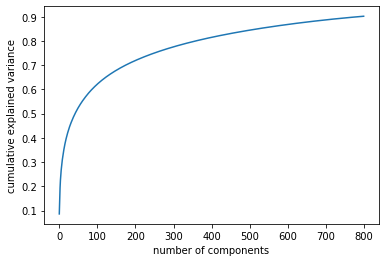

In [30]:
pca = decomposition.PCA(n_components=800)
pca.fit(QAmodel.inferst.embeddings)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
emb = pca.transform(QAmodel.inferst.embeddings)
emb

### 2) Tests of sentence embeddings models with cloud visualisation https://github.com/facebookresearch/InferSent 

In [303]:
def normalize(array):
    return array/np.linalg.norm(array)

In [309]:
MODEL_PATH = 'dataset/encoder/infersent2.pkl' 
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
infersent = InferSent_(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [310]:
W2V_PATH = 'dataset/fastText/crawl-300d-2M.vec'
dic=infersent.set_w2v_path(W2V_PATH)

In [ ]:
def get_w2v(self, word_dict):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with w2v vectors
        word_vec = {}
        with open(self.w2v_path) as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if word in word_dict:
                    word_vec[word] = np.fromstring(vec, sep=' ')
        print('Found %s(/%s) words with w2v vectors' % (len(word_vec), len(word_dict)))
        return word_vec

In [49]:
infersent.build_vocab_k_words(K=200000)
#infersent.update_vocab(list(QAmodel.voc))

Vocab size : 200000


In [36]:
embeddings = infersent.encode(['chocolate', 'dance','chemicals',
                               'clothes', 'safety'
                               ,'animals', 'environment', 'risk',
                              ],
                              tokenize=True)
q_str="'hazard products.'"
question=infersent.encode([q_str])

In [38]:
q_str=pdfconverter().remove_non_alpha(q_str)
q_str=q_str.replace('.','')
q_str

'hazard products'

In [39]:
embeddings_normalized=np.apply_along_axis(lambda v: normalize(v), 1,embeddings)
question_normalized=normalize(question)

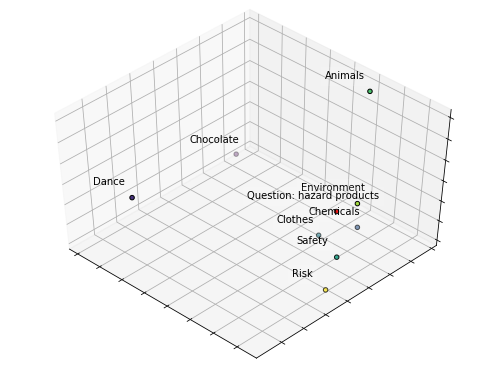

In [40]:
from sklearn import decomposition
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
iris = datasets.load_iris()
X =embeddings_normalized
Q=question_normalized
y=np.array(range(8))

fig = plt.figure(1, figsize=(7, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
Q=pca.transform(Q)
dic={'Chocolate':0, 'Dance':1, 'Chemicals':2,'Clothes':3,'Safety':4,'Animals':5, 'Environment':6,'Risk':7}

for name, label in dic.items():
    ax.text3D(X[y == label, 0].mean()+0.1,
              X[y == label, 1].mean(),
              X[y == label, 2].mean(),name,
              horizontalalignment='center',
              bbox=dict(alpha=.1, edgecolor='w', facecolor='w'))
    
ax.text3D(Q[0, 0].mean()+0.1,Q[0, 1].mean(),Q[0, 2].mean(),'Question: '+q_str,horizontalalignment='center',
          bbox=dict(alpha=.1, edgecolor='w', facecolor='w'))

# Reorder the labels to have colors matching the cluster results
y = np.choose(y, range(8)).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, edgecolor='k')
ax.scatter(Q[:,0],Q[:,1],Q[:,2],c='red',edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

In [42]:
embeddings_normalized.dot(question_normalized.T)

array([[0.6139592 ],
       [0.5630848 ],
       [0.7196866 ],
       [0.6994362 ],
       [0.70133   ],
       [0.6499989 ],
       [0.74974275],
       [0.6651032 ]], dtype=float32)

In [360]:
scores=embeddings_normalized.dot(question_normalized.T)
df=pd.DataFrame(np.c_[scores,y],columns=['scores','label']).sort_values(by=['scores'],ascending=False)
df['label']=df['label'].apply(lambda k: list(dic.keys())[list(dic.values()).index(k)])
df

,scores,label
6,0.749743,Environment
2,0.719687,Chemicals
4,0.701330,Safety
3,0.699436,Clothes
7,0.665103,Risk
5,0.649999,Animals
0,0.613959,Chocolate
1,0.563085,Dance


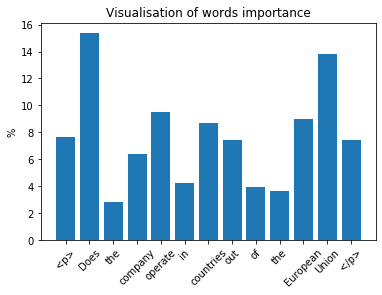

[7.6171875,
 15.380859375,
 2.8564453125,
 6.4208984375,
 9.4970703125,
 4.2724609375,
 8.6669921875,
 7.421875,
 3.9306640625,
 3.662109375,
 9.0087890625,
 13.818359375,
 7.4462890625]

In [66]:
obs=QAmodel.inferst.infersent.visualize('Does the company operate in countries out of the European Union')
obs[2]

### 3) Elastic Search for faster indexing

### 4) Automatic Querry Generator (using Infersent word importance)

In [39]:
def generate_querry(querries):
    querries=[pdfconverter().remove_non_alpha(q) for q in querries]    
    sentences=[s[0].lower()+s[1:].replace('?','')  for s in querries]
    i=0
    important_words=[]
    unsorted_words=[]
    
    for qu in sentences:
        
        #Get scores from infersent visualization function (max-pooling et each layer)
        tensor,vector,scores,words=QAmodel.inferst.infersent.visualize(qu)
        scores=np.array(scores[1:len(scores)-1])
        words=np.array(words[1:len(words)-1])
        
        #Remove stopwords from querries and attributed scores
        pos=[i for i,c in enumerate(list(words)) if c not in QAmodel.retriever.stop_words_list]
        words=words[pos]
        scores=np.array(scores)[pos]
        scores=scores/np.sum(scores)
        
        #Sort query words by word importance keeping idx in memory to unsort it back
        data=pd.DataFrame(np.c_[words,scores],columns=['word','score'])
        idx=np.argsort(-np.array(data.score.values,dtype='float64'))
        idx_unsort=np.argsort(idx)
        data=data.sort_values(by=['score'],ascending=False)
        new_words=data.word.values
        new_scores=np.array(data.score.values,dtype=float)
        
        #Keeping a set of words that satisfy 70% of cumulative importance
        score_cum=np.cumsum(new_scores)
        pos=score_cum<0.75
        lw=new_words[pos]
        ls=new_scores[pos]
        lw_unsort=words[pos[idx]]
        
        important_words.append(lw)
        unsorted_words.append(lw_unsort)
        i+=1
    
    return pd.DataFrame(np.c_[querries, important_words,unsorted_words],columns=['query','words_sort','words_unsort'])

## Test on annual reports of top chemicals companies 

In [38]:
questions=['Does the company operate in countries out of the European Union?',
'Is at least one of the company’s production facilities classified as SEVESO « High » (European Detective) or equivalent in other countries',
'Is the Company involved in agricultural chemistry activities, including the production of nitrogenous potash and phosphate based fertilizers?',
'Has the company formalized a commitment (policy or program) to control and reduce pollution (water air and sol)?',
'Does the company have an emergency plan and a remediation plan to cope with the consequences of industrial accidents and to ensure business continuity?',
           'Does the company have an emergency plan and a remediation plan to cope with the consequences of industrial accidents?',
'Has the company formalized  a strategy to reduce its greenhouse gas  emissions?',
'Has the company implemented measures to reduce its greenhouse gas emissions, use of low-carbon energy sources and energy recovery and efficiency system?',
'Does the company monitor performance indicators to assess its progress compared to its climate related commitments?',
'Does the company monitor performance indicators to assess its progress with regard to energy consumption  per tons produced?',
'Does the company monitor performance indicators to assess its progress with regard to greenhouse gas emissions?',
'Does the company have a formalized commitment policy (policy or program) that addresses the safety of its plants or facilities (implementation of safety procedures and standards, installation of secondary containment, maintenance etc..)',
'Does the company monitor performance indicators with regard to health & safety for aspects for workers relying on frequency or severity rates ?',
'Is there a crisis management scheme to cope with an identified issue on product safety?']

#data=generate_querry(questions)
#data     

In [40]:
questions=['Does the company operate in countries out of the European Union?',
'Is at least one of the company’s production facilities classified as Seveso « High » (European Detective) or equivalent in other countries',
          ]
data=generate_querry(questions)
data     

,query,words_sort,words_unsort
0,Does the company operate in countries out of the European Union,"[Union, does, operate, countries]","[company, operate, countries, Union]"
1,Is at least one of the companys production facilities classified as Seveso High European Detective or equivalent in other countries,"[Seveso, countries, Detective, facilities, classified, production]","[companys, classified, Seveso, High, Detective, countries]"


### Get Answers and display it nicely

In [1]:
from IPython.display import display
cq=1
answers_tf=[]
answers_if=[]
answers_be=[]
qux=[]
for q in questions:
    for j in range(2):
        qux.append(q)
sequence=['Sanofi','BasF']*len(data.words_unsort)
for i in range(0,len(data.words_unsort)):
    L=data.loc[i,'words_unsort']
    for x in range(2):
        d1,d2,d3=QAmodel.predict(' '.join(L), VE_type='DP',range_chunks=(8,35))
        d3,d4,d5=QAmodel.predict(questions[i], VE_type='DP',range_chunks=(8,35))
        contextd1=str([ c+" ( "+str(np.round(float(d1.scores.tolist()[i]),2))+" ) " for i,c in  enumerate(d1.context.tolist())])
        contextd4=str([ c+" ( "+str(np.round(float(d4.score.tolist()[i]),2))+" ) " for i,c in  enumerate(d4.context.tolist())])
        contextd5=str([ c+" ( "+str(np.round(float(d5.score.tolist()[i]),2))+" ) " for i,c in  enumerate(d5.context.tolist())])
        answers_tf.append(contextd1)
        answers_if.append(contextd4)
        answers_be.append(contextd5)
data_show=pd.DataFrame(np.c_[qux,sequence,answers_tf,answers_if,answers_be],columns=['Question','Company','Tf-Idf','Infersent','Bert'])

NameError: name 'questions' is not defined

In [111]:
data_show=pd.DataFrame(np.c_[qux,sequence,answers_tf,answers_if,answers_be],columns=['Question','Company','Tf-Idf','Infersent','Bert'])

NameError: name 'sequence' is not defined

In [16]:
QAmodel.tf_idf_farahat.TF_FARAHAT_emb.shape

(7845, 1178)

In [158]:
data_show

,Question,Company,Tf-Idf,Infersent,Bert
0,Does the company operate in countries out of the European Union?,Sanofi,"['It encompasses how Sanofi promotes and respects human rights in our business operations in all countries where we operate. ( 0.59 ) ', 'In all countries where we operate, we seek to strike a bal...","['European countries including the United Kingdom, Belgium, France, Germany, the Netherlands, Italy and Norway. ( 0.51 ) ', 'European Patent Convention accession of some current European Patent Co...","['European countries including the United Kingdom, Belgium, France, Germany, the Netherlands, Italy and Norway. ( 0.58 ) ', 'Specific situations may vary by country, most notably with respect to o..."
1,Does the company operate in countries out of the European Union?,BasF,"['The working conditions of our employees are, at minimum, in compliance with internationally recognized labor standards and the laws of the countries we operate in. ( 0.61 ) ', 'BASF will hold a ...","['The “IAS Regulation” made the application of IFRSs mandatory for listed companies headquartered in the European Union starting in 2005. ( 0.48 ) ', 'This is why the BASF Europa Betriebsrat (Euro...","['This is why the BASF Europa Betriebsrat (European Works Council) addresses cross-border matters in Europe. ( 0.6 ) ', 'For certain companies outside the eurozone or U.S. dollar zone, the euro or..."
2,Is at least one of the company’s production facilities classified as Seveso « High » (European Detective) or equivalent in other countries,Sanofi,"['The French chemical manufacturing sites in Aramon, Sisteron and Vertolaye, as well as the plants located in the Hoechst Industry Park in Frankfurt, Germany, and the chemical production site in B...","['Our headquarters are located in France and the intellectual property of many of\xa0our\xa0leading products originates from Western Europe. ( 0.37 ) ', 'European Patent Convention accession of so...","['Global markets are supplied from our facilities at Compiègne (France), Origgio (Italy), Cologne (Germany) and Veresegyház (Hungary). ( 0.54 ) ', 'INFORMATION ON THE COMPANYcomposed of a central ..."
3,Is at least one of the company’s production facilities classified as Seveso « High » (European Detective) or equivalent in other countries,BasF,"['BASF will lose control over the oil and gas activities as a result of the agreements signed by the shareholders on the management of the newly created company, and therefore classified these act...","['These include the Verbund site in Geismar, Louisiana, as well as another 19 sites in Brazil, India, Malaysia, Thailand, France and the Netherlands, among other countries. ( 0.33 ) ', 'At the Lud...","['Specifically, this refers to Solvay’s production plants and innovation competencies in the engineering plastics field in Europe. ( 0.47 ) ', 'For certain companies outside the eurozone or U.S. d..."
4,"Is the Company involved in agricultural chemistry activities, including the production of nitrogenous potash and phosphate based fertilizers?",Sanofi,"['Muzammil Mansuri Executive Vice President, Strategy and Business Development Date of birth: January 20, 1954 Muzammil Mansuri holds a Bachelor of Science degree in Chemistry and a Ph.D. in Organ...","['The term “Regenerative Medicinal Products” used in the law includes cellular and tissue-based products and gene therapies. ( 0.48 ) ', 'Nutritionals ■ Pharmaton® is a range of products which con...","['Nutritionals ■ Pharmaton® is a range of products which contain vitamins, minerals and standardized Ginseng Extract G115. ( 0.56 ) ', 'Waste generated in operations: 371,036 tCO2 e Definition: Th..."
5,"Is the Company involved in agricultural chemistry activities, including the production of nitrogenous potash and phosphate based fertilizers?",BasF,"['Research here concentrates on supramolecular chemistry as well as nanotechnology and polymer chemistry. ( 0.35 ) ', 'In addition, we are also involved in initiatives such as workshops

In [187]:
!ls

InferSent-master   cdQA-master        envblackjack       ques.pdf
PrésentationCDQA   cdQA-master.zip    include            requirements.txt
Q&A_t.ipynb        data               lib                restats
Untitled.ipynb     dataset            models             results
__pycache__        dev-v1.1.json      models.py          run_squad.py
bin                env                pdf_files          train-v1.1.json


In [189]:
data_show.to_csv('Chemicals.csv')

### Choose answers program

In [17]:
from IPython.display import display
cq=1
answers_tf=[]
answers_if=[]
answers_be=[]
for i in range(0,len(data.words_unsort)):
    L=data.loc[i,'words_unsort']
    #d1,d2=QAmodel.predict(' '.join(L), VE_type='DP',range_chunks=(8,35))
    d1,d2,d3=QAmodel.predict(' '.join(L), VE_type='DP',range_chunks=(8,35))
    d3,d4,d5=QAmodel.predict(questions[i], VE_type='DP',range_chunks=(8,35))
    print('Question {}:  {}'.format(cq,questions[i]))
    cq+=1
    display(d1[['context','scores']])
    ix=str(input('Choose for Tf-Idf (press enter if nothing is pertinent)'))
    if ix!='':
        answers_tf.append(d1['context'].tolist())
    else:
        answers_tf.append('')
    display(d4[['context','score']])
    ix=str(input('Choose for Infersent (press enter if nothing is pertinent)'))
    if ix!='':
        answers_if.append(d4['context'].tolist())
    else:
        answers_if.append('')
    
    display(d5[['context','score']])
    ix=str(input('Choose for Bert (press enter if nothing is pertinent)'))
    if ix!='':
        answers_be.append(d5['context'].tolist())
    else:
        answers_be.append('')
    
data_show=pd.DataFrame(np.c_[questions,answers_tf,answers_if,answers_be],columns=['Questions', 'Tf-Idf best answer', 'Infersent best answer','Bert best answer'])



 Choose a repository 

  directory
0    Others
1    Sanofi

1


 Choose a repository 

  directory
0    Others
1    Sanofi

1
Question 1:  Does the company operate in countries out of the European Union


,context,scores
0,It encompasses how Sanofi promotes and respects human rights in our business operations in all countries where we operate.,0.5658546096670526
1,"In all countries where we operate, we seek to strike a balance between our economic interests and those of our employees, which we regard as inseparable.",0.546178560807816
3,"This category is mostly applicable to companies that operate leased assets (i.e., lessees), but can also be applicable to all companies leasing assets.",0.47139165377872655
4,"We also operate other insurance programs, but these are of much lesser importance than those described above.",0.3759826144492756
2,"We operate our business through office premises and research, production and logistics facilities in approximately 100 countries around the world.",0.3157031957615065


Choose for Tf-Idf (press enter if nothing is pertinent) 


,context,score
0,"European countries including the United Kingdom, Belgium, France, Germany, the Netherlands, Italy and Norway.",0.5180734
1,"European Patent Convention accession of some current European Patent Convention Member States, resulting in different treatment in those countries.",0.48480105
2,Our headquarters are located in France and the intellectual property of many of our leading products originates from Western Europe.,0.4561284
3,The granted “European Patent” establishes corresponding national patents with uniform patent claims among the Member States.,0.45545483
4,"The principal markets for Lemtrada® in terms of sales are the US, the UK, Germany, Spain, Canada and Italy.",0.44236198


Choose for Infersent (press enter if nothing is pertinent) 


,context,score
0,"European countries including the United Kingdom, Belgium, France, Germany, the Netherlands, Italy and Norway.",0.5767701
1,"Specific situations may vary by country, most notably with respect to older patents and to countries that have only recently joined the EU.",0.56638044
2,"European Patent Convention accession of some current European Patent Convention Member States, resulting in different treatment in those countries.",0.5300329
3,"While EU regulatory exclusivity is intended to be applied throughout the EU, in some cases Member States have taken positions prejudicial to our exclusivity rights.",0.516057
4,"Operating Foreign Exchange Risk A substantial portion of our net sales is generated in countries where the euro, which is our reporting currency, is not the functional currency.",0.49603373


Choose for Bert (press enter if nothing is pertinent) 


 Choose a repository 

  directory
0    Others
1    Sanofi

1


 Choose a repository 

  directory
0    Others
1    Sanofi

1
Question 2:  Is at least one of the companys production facilities classified as Seveso High European Detective or equivalent in other countries


,context,scores
3,"The French chemical manufacturing sites in Aramon, Sisteron and Vertolaye, as well as the plants located in the Hoechst Industry Park in Frankfurt, Germany, and the chemical production site in Budapest, Hungary, are listed Seveso III (from the name of the European directive that deals with potentially dangerous sites through a list of activities and substances associated with classification thresholds).",0.5982648233583138
2,"The Board of Directors noted that the Company and its subsidiaries had, in the normal course of business, over the past three years, sold products and provided services to, and/or purchased products and received services from, companies in which certain of the Company’s directors who are classified as independent (or their close family members) were senior executives or employees during 2017.",0.4527138648971805
4,"Finally, in the event of changes to a plan of sale that require an asset no longer to be classified as held for sale, IFRS 5 specifies the following treatment:\n■ The assets and liabilities previously classified as held for sale are reclassified to the appropriate balance sheet line items, with no restatement of comparative periods.",0.303648663105362
0,"These assets are classified in the balance sheet within the line items Other non-current assets, Other current assets and Cash and cash equivalents.",0.27992655249436005
1,"European Patent Convention accession of some current European Patent Convention Member States, resulting in different treatment in those countries.",0.2119383891071344


Choose for Tf-Idf (press enter if nothing is pertinent)


,context,score
0,Our headquarters are located in France and the intellectual property of many of our leading products originates from Western Europe.,0.3766396
1,"European Patent Convention accession of some current European Patent Convention Member States, resulting in different treatment in those countries.",0.34062135
2,"More than \n30 production plants, including the majority of our plants and over half our Research and Development sites are also located in Western Europe.",0.32603288
3,"We operate our business through office premises and research, production and logistics facilities in approximately 100 countries around the world.",0.3235063
4,"Sanofi Global Quality unites all 9,000 employees operating in the Company’s global quality functions, operational quality units and Medical, Clinical and Country organizations.",0.3128326


Choose for Infersent (press enter if nothing is pertinent)


,context,score
0,"Global markets are supplied from our facilities at Compiègne (France), Origgio (Italy), Cologne (Germany) and Veresegyház (Hungary).",0.53888655
1,INFORMATION ON THE COMPANYcomposed of a central division (headquartered in Paris) and several local and regional divisions in the contracting Member.,0.528618
2,"Through patent and other proprietary rights such as data exclusivity or supplementary protection certificates in Europe, we hold exclusivity rights for a number of our research-based products.",0.52614295
3,Our headquarters are located in France and the intellectual property of many of our leading products originates from Western Europe.,0.5231866
4,"Between 1994 and 2004 he held increasingly senior functional and franchise leadership roles in research and development in Glaxo, SmithKline Beecham and GlaxoSmithKline, in Europe and the US.",0.5152808


Choose for Bert (press enter if nothing is pertinent)


 Choose a repository 

  directory
0    Others
1    Sanofi

1


 Choose a repository 

  directory
0    Others
1    Sanofi

1
Question 3:  Is the Company involved in agricultural chemistry activities including the production of nitrogenous potash and phosphate based fertilizers


,context,scores
1,"Muzammil Mansuri Executive Vice President, Strategy and Business Development Date of birth: January 20, 1954 Muzammil Mansuri holds a Bachelor of Science degree in Chemistry and a Ph.D. in Organic Chemistry from University College London.",0.38689201047307187
2,"These guidelines set out the requirements on preclinical, clinical and Chemistry, Manufacturing and Control (CMC) data to be considered for the development of the new application category of biosimilars.",0.29739084193823334
0,"Sanofi is involved in several programs to minimize the potential environmental impacts of medicines, including: Evaluating and minimizing the environmental impacts of manufacturing activities.",0.24298416198814726
4,"Sciences in 2017, a company whose influenza vaccine production technology will allow Sanofi Pasteur to expand its production expertise and capacity.",0.2091346135215787
3,Since 2013 Member of the Scientific Advisory Board of the Shemyakin-Ovchinnikov Institute of Bio-Organic Chemistry (Russia).,0.1950289238428835


Choose for Tf-Idf (press enter if nothing is pertinent)


,context,score
0,The term “Regenerative Medicinal Products” used in the law includes cellular and tissue-based products and gene therapies.,0.49991506
1,"Nutritionals\n■ Pharmaton® is a range of products which contain vitamins, minerals and standardized Ginseng Extract G115.",0.4422735
2,"In Emerging Markets:\n• Full Sanofi pharma portfolio: Solutions for Diabetes, Cardiovascular diseases, Specialty Care medicines, Established Products and .",0.42354715
3,"Production of biological, chemical and pharmaceutical products is the responsibility of our Industrial Affairs department, which is also in charge of most of our logistics facilities (distribution and storage centers).",0.40692127
4,Note that Emerging Markets sales of Diabetes & Cardiovascular and Specialty Care products are included in the General Medicines & Emerging Markets GBU.,0.3988991


Choose for Infersent (press enter if nothing is pertinent)


,context,score
0,"Nutritionals\n■ Pharmaton® is a range of products which contain vitamins, minerals and standardized Ginseng Extract G115.",0.56347585
1,"Waste generated in operations: 371,036 tCO2 e Definition: This category includes emissions from third-party disposal and treatment of waste that is generated in Sanofi-owned or controlled operations.",0.53754044
2,The GHG emissions related to the processing of these APIs into final medicines at clients’ plants is part of this category.,0.5106852
3,"Our Rare Diseases business is focused on products for the treatment of rare genetic diseases and other rare chronic debilitating diseases, including lysosomal storage disorders (LSDs), a group of metabolic disorders caused by enzyme deficiencies.",0.4815372
4,Since 2013 Member of the Scientific Advisory Board of the Shemyakin-Ovchinnikov Institute of Bio-Organic Chemistry (Russia).,0.4738804


Choose for Bert (press enter if nothing is pertinent)


 Choose a repository 

  directory
0    Others
1    Sanofi

1


 Choose a repository 

  directory
0    Others
1    Sanofi

1
Question 4:  Has the company formalized a commitment policy or program to control and reduce pollution water air and sol


,context,scores
1,"It requires the full commitment of the entire Company, from top executives to each individual in our operations around the globe.",0.3920099391109528
0,"On January 2019, the Ministry for Environment launched the national clean air programme (NCAP), a scheme to provide the states and the union government with a framework to combat air pollution.",0.31624560176505606
4,"The Directors & Officers Liability program protects all legal entities under our control, and their directors and officers.",0.29804724777883396
2,The Company’s management is responsible for maintaining effective internal control over financial reporting and for its assessment of the effectiveness of internal control over financial reporting included in the accompanying Report of Management on Internal Control Over Financial Reporting.,0.27406098771514736
3,"(c) Irrevocable purchase commitments given as of December 31, 2017 include €1,207 million of commitments to joint ventures.",0.2703509356375344


Choose for Tf-Idf (press enter if nothing is pertinent)


,context,score
0,Responsible use of water: specific operating procedures govern the use of water during manufacturing and heat exchanges and promote reduced consumption.,0.41528153
1,"Deforestation, water pollution, clean water shortages, and waste management are further issues of concern.",0.37438285
2,"We have also set ourselves the target of achieving sustainable water resource management, especially at sites which are under hydric stress.",0.37166452
3,This study was designed to identify activities that could be modified to reduce energy consumption and CO2 emissions.,0.3652539
4,Sites at potential risk from water scarcity also must establish and comply with a plan for reducing water consumption tailored to the site’s local context and industrial characteristics.,0.35788453


Choose for Infersent (press enter if nothing is pertinent)


,context,score
0,The SBTi provides a framework for companies to define how much and how quickly we must reduce our GHG emissions.,0.7437533
1,Sanofi is committed to reducing our carbon footprint by adopting responsible practices to reduce our greenhouse gas emissions throughout the world.,0.66050047
2,"The Company is committed to closely managing and reducing our environmental footprint (e.g., carbon emissions), ensuring that products and waste are appropriately managed by internal teams and third parties, anticipating potential business discontinuity due to less available resources and adapting solutions to respond to the effects of climate change on public health.",0.65487695
3,Sites at potential risk from water scarcity also must establish and comply with a plan for reducing water consumption tailored to the site’s local context and industrial characteristics.,0.648137
4,Responsible use of water: specific operating procedures govern the use of water during manufacturing and heat exchanges and promote reduced consumption.,0.6293419


Choose for Bert (press enter if nothing is pertinent)


 Choose a repository 

  directory
0    Others
1    Sanofi

1


 Choose a repository 

  directory
0    Others
1    Sanofi

1
Question 5:  Does the company have an emergency plan and a remediation plan to cope with the consequences of industrial accidents and to ensure business continuity


,context,scores
2,"■ Provisions for environmental risks and remediation amount to\n€686 million in 2017, the majority of which are related to contingencies that have arisen from business divestitures.",0.33451365704476965
0,"To safeguard continuity of operations and secure timely execution of its core tasks, the EMA has launched a Business Continuity Plan\n(BCP).",0.33251818041499887
3,Global economic conditions and an unfavorable financial environment could have negative consequences for our business(2).,0.28071449675747484
4,See also below “– Global economic conditions and an unfavorable financial environment could have negative consequences for our business”.,0.28071449675747484
1,Provisions for environmental risks and remediation mainly relate to contingencies arising from business divestitures.,0.25248864839309804


Choose for Tf-Idf (press enter if nothing is pertinent)


,context,score
0,Provisions for environmental risks and remediation mainly relate to contingencies arising from business divestitures.,0.36727214
1,Our Industrial Affairs Department has an ongoing policy of adapting industrial facilities to market needs.,0.34481108
2,Our Industrial Affairs Department has an ongoing policy of adapting industrial facilities to market needs.,0.34481108
3,Our Industrial Affairs Department has an ongoing policy of adapting industrial facilities to market needs.,0.34481108
4,Sanofi’s activities Supply chain Access to healthcare for the underserved Product quality and patient safety Business ethics.,0.3328748


Choose for Infersent (press enter if nothing is pertinent)


,context,score
0,and result in better knowledge of risk in the workplace to promote the implementation of preventive measures.,0.66125154
1,"The complexity of these processes, as well as strict internal and health authority standards for the manufacture of our products, subject us to risks because the investigation and remediation of any identified or suspected problems can cause production delays, substantial expense, product recalls or lost sales and inventories, and delay the launch of new products; this could adversely affect our operating results and financial condition, and cause reputational damage and the risk of product liability (see “– Product liability claims could adversely affect our business, results of operations and financial condition above”).",0.6364193
2,Our target is to focus the company’s efforts on actions to pro-actively prevent potentially serious accidents rather than limiting efforts to post-accidental corrective measures.,0.6277626
3,Environmental Risks of Our Industrial Activities Risks from the handling of hazardous materials could adversely affect our results of operations.,0.6238846
4,"With a focus on prevention, each year the number of occupational diseases is consolidated at company level with the aim of improving, year by year, the level of available information according to local regulations, which may differ from one country to another.",0.6234863


KeyboardInterrupt: 

In [ ]:
from IPython.display import display
cq=1
answers_tf=[]
answers_if=[]
answers_be=[]
for i in range(0,len(data.words_unsort)):
    L=data.loc[i,'words_unsort']
    #d1,d2=QAmodel.predict(' '.join(L), VE_type='DP',range_chunks=(8,35))
    d1,d2,d3=QAmodel.predict(' '.join(L), VE_type='DP',range_chunks=(8,35))
    d3,d4,d5=QAmodel.predict(questions[i], VE_type='DP',range_chunks=(8,35))
    print('Question {}:  {}'.format(cq,questions[i]))
    cq+=1
    display(d1[['context','scores']])
    ix=str(input('Choose for Tf-Idf (press enter if nothing is pertinent)'))
    if ix!='':
        answers_tf.append(d1.loc[int(ix),'context'])
    else:
        answers_tf.append('')
    display(d4[['context','score']])
    ix=str(input('Choose for Infersent (press enter if nothing is pertinent)'))
    if ix!='':
        answers_if.append(d4.loc[int(ix),'context'])
    else:
        answers_if.append('')
    display(d5[['context','score']])
    ix=str(input('Choose for Bert (press enter if nothing is pertinent)'))
    if ix!='':
        answers_be.append(d5.loc[int(ix),'context'])
    else:
        answers_be.append('')
pd.DataFrame(np.c_[questions,answers_tf,answers_if,answers_be],columns=['Questions', 'Tf-Idf best answer', 'Infersent best answer','Bert best answer'])

### Sources

- Useful Github pages
-  <https://github.com/UKPLab/sentence-transformers>
- < https://github.com/huggingface/pytorch-transformers>
- < https://github.com/cdqa-suite>
- Google Brain Original Paper:
- < https://nlp.stanford.edu/seminar/details/jdevlin.pdf?fbclid=IwAR2TBFCJOeZ9cGhxB-z5cJJ17vHN4W25oWsjI8NqJoTEmlYIYEKG7oh4tlY>
<  http://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf>
- Tf-Idf semantic expansion
- < https://www.sciencedirect.com/science/article/pii/S1877050916311589 >


## Semantic Expansion:  Enhancement of tf-idf model with the information provided by co-occurence of terms within documents <http://www2015.wwwconference.org/documents/proceedings/companion/p805.pdf>

#### Let's start with few interestings statistics :  

###### Average document length:

In [18]:
np.mean([len(x) for x in QAmodel.content])

176.320530815363

##### Tf_iDf matrix dimension and sparsity of the matrix

In [298]:
(c,d)=(len(QAmodel.content),len(QAmodel.retriever.vectorizer.get_feature_names()))
print("(documents,vocab)=",(c,d))

(documents,vocab)= (7843, 6896)


In [299]:
T=QAmodel.retriever.tfidf_matrix
T

<7843x6896 sparse matrix of type '<class 'numpy.float64'>'
	with 111515 stored elements in Compressed Sparse Row format>

In [300]:
(a,b)=T.shape
non_zeros=100*np.sum(np.abs(T)>0)/(a*b) 
print('Tf-Idf Matrix is',100-np.round(non_zeros,2),'% sparse')

Tf-Idf Matrix is 99.79 % sparse


Two observations: 
- Each document is approximately a tweet: that's short !   
- Tf-idf matrix is a (very) sparse matrix

Idea : In this project we want to return a text chunk, among those with the highest similarities with the querry.
However Tf-Idf is bad for small document (here a document is one or two sentences). Yan et al mentioned that for short texts using tf-idf is not very efficient since term frequency in all documents is not a good
measure to capture the discriminative power of the data due to the sparsity.
Short-text segments are typically represented by very sparse
vectors, where each has non-zero weights for only a very few
terms. In this case, traditional techniques for calculating
text similarity results in measures which are very close to
zeros. This is due to the fact that documents, even the
very similar ones, do have a very few or mostly no terms in
common. In order to alleviate this limitation, we need to
enriched the representation of short-text segments by incorporating information about correlation between terms. Towards achieving this goal, we employ a method for enhancing document clustering using statistical semantics proposed by Farahat and Kamel and enhance it to handle large amounts of short documents. This is done by the following semantic kernel formula : $$K=X^{t}GX \hspace{4pt} \text{where} \hspace{4pt} G \hspace{4pt} \text{is the}\hspace{3pt} mxm \hspace{3pt} \text{term correlation matrix} \hspace{3pt} \text{and}\hspace{3pt} X^{t} \hspace{3pt} \text{is the tf-idf matrix with stemming and stopword removal} $$
$$\text{Problem : To compute the matrix} \hspace{2pt} G: \text{ the time complexity is} \hspace{2pt} O(n^2)$$
$$ \text{Solution : Factorisation method suggested by Nystrom }$$

### Term selection for correlation matrix : 

##### First we select words that have a sufficent frequency throughout documents (set to 1%)

#### We perform a random sampling of 20% of the terms using term-importance probabilities. The importance probability of a term is given by the length of his vector sparse representation inside the tf-idf matrix

In [31]:
def select_term_Naystrom(T,s=1.0):
    
    #T is the Tf-Idf Matrix 
    #s is the fraction of important words that we want to retrieve (s=1.0 generally)
    
    #Here are all the stems of tf-idf vocabulary
    terms=QAmodel.retriever.vectorizer.get_feature_names()
    
    #First we want to remove digits that are not important terms
    n=int(s*len(terms))
    idx_words=[]
    for i,term in enumerate(terms):
        try: float(term)
        except: idx_words.append(i)
   
    #Secondly we set a threshold to select words that appear at least each p documents 
    threshold=0.002 #Set threshold to select words that appear at least each p documents 
    freq_term=np.zeros((len(QAmodel.content),len(terms)))
    for j,sentence in enumerate(QAmodel.content):
        stem=QAmodel.retriever.tokenize(sentence) 
        for i,c in enumerate(terms):
            if c in stem:
                freq_term[j,i]+=1
    freq_term_by_doc=np.apply_along_axis(lambda x: np.mean(x),0,freq_term)
    ids=np.where(freq_term_by_doc>threshold)[0]
    idx_words=[ i for i in ids if i in idx_words]
    

    #Init selection of terms with most correlation 
    if s!=1.0:
        prob=np.sum(np.abs(T)>0,axis=0)
        prob=prob/np.sum(prob)
        prob=np.squeeze(prob)
        idx=[]
        m=len(idx_words)

        for i in range(n):

            p=int(np.random.choice(m,1,prob[0]))
            idx.append(int(idx_words[p]))
            prob[idx_words[p]]=0
            prob=prob/np.sum(prob)

        return idx,np.squeeze(T[:,idx])
    else:
        idx=idx_words
        return idx,np.squeeze(T[:,idx])

        

##### 1)Proceed First step

In [32]:
M=QAmodel.retriever.tfidf_matrix.toarray()
idx,A=select_term_Naystrom(M)
A.shape

(7843, 1178)

#### Visualize terms selected

In [301]:
[QAmodel.retriever.vectorizer.get_feature_names()[i] for i in idx[80:90]]

['area',
 'aris',
 'arrang',
 'articl',
 'asia',
 'ask',
 'aspect',
 'assess',
 'asset',
 'assist']

### Implementation of  Farahat - Nystrom method to compute the semantic Kernel and overcome sparcity 

Nystrom Method Explained: 

$$\text{Let} \hspace{3pt} X^T \hspace{3pt} \text{be our tf-idf matrix whose element} \hspace{3pt}X_{i,j} \hspace{3pt}\text{represents the weight of term i inside document j }$$
$$ \text{We want to express a semantic kernel K which includes the correlation between important terms and factorize it to get new sentence embeddings  } $$ $$ \text{Formally we want to approximate:}\hspace{3pt} K=X^TGX \hspace{3pt} \text{as the product: }\hspace{3pt} K\simeq W^{T}W \hspace{3pt} \text{where} \hspace{3pt} W=Z^{T}X \hspace{3pt}\ $$ $$\leftrightarrow  \hspace{3pt} \text{Equivalently : } \hspace{3pt} G=L_{X}^{-1/2}XX^{T}L_{X}^{-1/2}\hspace{5pt} \text{is approximated by}\hspace{3pt} G \simeq ZZ^{T} \hspace{4pt}  $$
The important idea is that K is a squarred matrix of document size and W is of shape (documents,term). Hence K stands as the similarity matrix between sentences and W is the sentence embedding matrix. Moreover K and W incorporate the correlation between terms provided by G. This is what we was looking for ! 
$$ \text{Such approximation for G is suggested by Nystrom in this formula} \hspace{3pt}\hat{G}=G_{:S}G_{SS}^{-1}{}G_{:S}^{T} \hspace{3pt} \text{where S is the set of selected terms}\hspace{4pt} \text{The important terms are selected given a frequency threshold.}  $$
$$ \text{Then our approximation is} \hspace{3pt} Z=G_{:S}G_{SS}^{-1/2} \hspace{3pt} \text{with G (correlation matrix)} \hspace{3pt} \text{defined as} \hspace{3pt} G=L_{X}^{-1/2}XX^{T}L_{X}^{-1/2} $$
$$ \text{It follows that } \hspace{3pt} W=Z^{T}X=(G_{:S}G_{SS}^{-1/2})^{T}X=(X_{S:}X_{S:}^{T})^{-1/2}X_{S:}X_{S:}^{T} L_{X}^{-1/2}X$$
$$ \text{We can now perform the Spherical K-means on the sentence embedding matrix } \hspace{3pt} W^T \hspace{3pt} \text{! } \hspace{3pt}  $$ Spherical K-means seeks to minimize cosine dissimilarity instead of euclidian distance.  $$ \text{Formally : } \hspace{4pt}𝐽=∑_{𝑖}𝑑(𝑥_𝑖,𝑝𝑐(𝑖)) \hspace{3pt} \text{where} \hspace{3pt} 𝑑(𝑥,𝑝)=1−𝑐𝑜𝑠(𝑥,𝑝)=\frac{⟨𝑥,𝑝⟩}{‖𝑥‖‖𝑝‖}$$
It is greatly used in NLP tasks since. One other major reason opting cosine similarity over euclidean distance will be to avoid ineffectiveness of euclidean distance when handling high dimensionality and sparse dataset. An other reason is that cosine dissimilarity doesn't account for differences of size between documents.

Enhancement of the method : We can perform a low rank SVD to compute $G_{SS}^{-1/2}$, that reduces the dimension of the semantic space to k. It makes the clustering algorithm even more efficient and reduces drastically time complexity.  We use the following SVD decomposition: $G_{SS}=UDU^T$ where $U$ is a $(k,l)$, ($k\leq l$ ) matrix which contains the k-eigen vectors associated with the k highest eigen values in the standard SVD decomposition $$ \text{Finally} \hspace{3pt} G_{SS}^{-1/2}=UD^{-1/2}U  \hspace{3pt} \text{which gives us}  \hspace{3pt}W=D^{-1/2}U^{T}X_{S:}X^TX$$

Ajout des querries dans le corpus pour la méthode de Naystrom, approximation low rank de la matrice W

In [41]:
def generate_kernel_decomposition(rank=None,subset=[]):
    if rank==None:
        rank=len(subset)
    ids=subset
    querries=data['words_sort'].tolist()
    for i,q in enumerate(querries):
        q=' '.join(list(q))
        q=q.lower()
        q=pdfconverter().remove_non_alpha(q)
        q=q.replace('.','')
        querries[i]=q
        
    qemb=QAmodel.retriever.vectorizer.transform(querries).toarray().transpose()
    X=QAmodel.retriever.tfidf_matrix.toarray().transpose()
    print(qemb.shape,X.shape)
    X=np.c_[X,qemb]
    
    L=np.eye(X.shape[0])*np.sqrt(X.shape[0])
    L_inv=np.linalg.inv(L)
    G=L_inv@X@X.transpose()@L_inv
    Gs=G[ids,:]
    Gs=Gs[:,ids]
    S,V,D=np.linalg.svd(Gs, full_matrices=True)
    Ssub,Vsub=S[:,:rank], np.diag(V)[:rank,:rank]
    #Ssub,Vsub=S,np.diag(V)
    #G=Ssub@Vsub$Ssub.transpose() but this operation is not necessary, we just need the decomposition of G
    
    D_sub_inv=np.diag(np.apply_along_axis(lambda x: 1/np.sqrt(x) , 0, V[:rank]))
    #D_sub_inv=np.diag(np.apply_along_axis(lambda x: 1/np.sqrt(x) , 0, V))
    W=(((D_sub_inv@Ssub.transpose())@X[ids,:])@(X.transpose()))@X
    return W
    
    


In [49]:
W=generate_kernel_decomposition(rank=500,subset=idx)

(6896, 14) (6896, 7843)


In [283]:
W.shape

(500, 7857)

In [50]:
W_=np.apply_along_axis(lambda x: x/np.sqrt(np.sum(x**2)), 1,W.transpose())
scores=W_@W_.transpose()
scores=scores[len(scores)-len(questions):,:len(scores)-len(questions)]
scores=scores[:,QAmodel.borders[2]:QAmodel.borders[3]]
scores.shape

(14, 4311)

In [358]:
W_=np.apply_along_axis(lambda x: x/np.sqrt(np.sum(x**2)), 1,W.transpose())
scores=W_@W_.transpose()
scores=scores[len(scores)-len(questions):,:len(scores)-len(questions)]
scores=scores[:,QAmodel.borders[1]:QAmodel.borders[2]]
scores.shape

(14, 3132)

### Finally: Spherical Kmeans cluster  + Bert Transformer to retrieve best candidates within each clusters

In [306]:
(a,b)=W_.shape
non_zeros=100*np.sum(np.abs(W_)>0)/(a*b) 
print('New Tf-Idf Matrix is',100-np.round(non_zeros,4),'% sparse')
print(a,b)

New Tf-Idf Matrix is 0.0 % sparse
7857 500


In [69]:
rank=np.apply_along_axis(lambda x:np.argsort(-x),1,scores)
repo=2 #Sanofi
raw_or_treated=1 #raw text
all_answers=[]
for question in range(14):
    answers=[]
    answers_raw=[]
    special_answers_raw=[]
    dic_answers={}
    count_answers=1
    print('*****  Question {} : {} {}'.format(question,questions[question],'********'))
    w_important=[w for w in questions[question].split(" ") if w=w.upper()]
    rk=0
    print('\n----------------\n')
    #Display best candidates according to clustering
    if w_important==[]:
        for answ in range(30):
            while True:
                answer_raw=QAmodel.contents_doc[repo][raw_or_treated][rank[question,rk]]
                answer=QAmodel.contents_doc[repo][1-raw_or_treated][rank[question,rk]]
                rk+=1
                dic_answers[answer]=dic_answers.get(answer,0)+1
                if dic_answers[answer]==1:
                    break
            answers.append(answer)
            answers_raw.append(answer_raw)
            
            #print('Anserw n°{} : {}'.format(count_answers,answer))
            #print('\n----------------\n')
            
    else:
        for w in w_important:
            w=QAmodel.retriever.tokenize(w)[0]
            print('token=', w)
            best_id=[i for i in range(rank.shape[1]) if w in QAmodel.contents_doc[repo][0][rank[question,i]].split(' ')][:2]
            for idd in best_id[:2]:
                print('Special Anserw n° {} : {}'.format(count_answers,QAmodel.contents_doc[repo][raw_or_treated][rank[question,idd]]))
                print('\n----------------\n')
                special_answers_raw.append(QAmodel.contents_doc[repo][raw_or_treated][rank[question,idd]])
                count_answers+=1
                rk+=1
            
        for answ in range(30):
            while True:
                answer_raw=QAmodel.contents_doc[repo][raw_or_treated][rank[question,rk]]
                answer=QAmodel.contents_doc[repo][1-raw_or_treated][rank[question,rk]]
                rk+=1
                dic_answers[answer_raw]=dic_answers.get(answer,0)+1
                if dic_answers[answer_raw]==1:
                    break
            answers.append(answer)
            answers_raw.append(answer_raw)#Cluster Tf-Idf 
            count_answers+=1
            rk+=1
            #transform question
            
    Qst=questions[question].lower()
    newQst=pdfconverter().remove_non_alpha(Qst)
    newQst=newQst.replace('.','')

    #Use Bert inside clusters
    bert=BertRetriever(top_n=5)
    embeddings = bert.transform(list([s for s in answers ]))
    indices,scores_bert=bert.predict(newQst,[0,len(answers)])
    scores_bert=scores_bert.loc[indices].values[:,0]
    text=[ answers_raw[i] for i in indices]
    
    for i,c in enumerate(text):
        print('Anserws n° {} : {}'.format(i+1,c))
        print('\n----------------\n')
    
    all_answers.append(answers)

            

*****  Question 0 : Does the company operate in countries out of the European Union? ********
Is there an Important Word? press enter if no :  

----------------

Anserws n° 1 : Specific situations may vary by country, most notably with respect to older patents and to countries that have only recently joined the EU.

----------------

Anserws n° 2 : We operate our business through office premises and research, production and logistics facilities in approximately 100 countries around the world.

----------------

Anserws n° 3 : In certain countries, we carry on some of our business operations through joint ventures with local partners.

----------------

Anserws n° 4 : In many European countries, automatic substitution of biologics is officially prohibited or not recommended.

----------------

Anserws n° 5 : In all countries where we operate, we seek to strike a balance between our economic interests and those of our employees, which we regard as inseparable.

----------------

Anserws

KeyboardInterrupt: 

In [66]:
rank=np.apply_along_axis(lambda x:np.argsort(-x),1,scores)
repo=1 #BasF
raw_or_treated=1 #raw text
all_answers=[]
for question in range(14):
    answers=[]
    answers_raw=[]
    dic_answers={}
    count_answers=1
    print('*****  Question {} : {} {}'.format(question,questions[question],'********'))
    w=str(input('Is there an Important Word? press enter if no :  '))
    rk=0
    print('\n----------------\n')
    #Display best candidates according to clustering
    if w=='':
        for answ in range(20):
            while True:
                answer_raw=QAmodel.contents_doc[repo][raw_or_treated][rank[question,rk]]
                answer=QAmodel.contents_doc[repo][1-raw_or_treated][rank[question,rk]]
                rk+=1
                dic_answers[answer]=dic_answers.get(answer,0)+1
                if dic_answers[answer]==1:
                    break
            answers.append(answer)
            answers_raw.append(answer_raw)
            
            #print('Anserw n°{} : {}'.format(count_answers,answer))
            #print('\n----------------\n')
            count_answers+=1
            rk+=1
    else:
        w=QAmodel.retriever.tokenize(w)[0]
        print('token=', w)
        best_id=[i for i in range(rank.shape[1]) if w in QAmodel.contents_doc[repo][0][rank[question,i]].split(' ')][:3]
        for idd in best_id[:2]:
            print('Special Anserw n° {} : {}'.format(count_answers,QAmodel.contents_doc[repo][raw_or_treated][rank[question,idd]]))
            print('\n----------------\n')
            count_answers+=1
            rk+=1
            
        for answ in range(30):
            while True:
                answer_raw=QAmodel.contents_doc[repo][raw_or_treated][rank[question,rk]]
                answer=QAmodel.contents_doc[repo][1-raw_or_treated][rank[question,rk]]
                rk+=1
                dic_answers[answer_raw]=dic_answers.get(answer,0)+1
                if dic_answers[answer_raw]==1:
                    break
            answers.append(answer)
            answers_raw.append(answer_raw)#Cluster Tf-Idf 
            count_answers+=1
            rk+=1
            #transform question
    Qst=questions[question].lower()
    newQst=pdfconverter().remove_non_alpha(Qst)
    newQst=newQst.replace('.','')

    #Use Bert inside clusters
    bert=BertRetriever(top_n=5)
    embeddings = bert.transform(list([s for s in answers ]))
    indices,scores_bert=bert.predict(newQst,[0,len(answers)])
    scores_bert=scores_bert.loc[indices].values[:,0]
    text=[ answers_raw[i] for i in indices]
    
    for i,c in enumerate(text):
        print('Anserws n° {} : {}'.format(i+1,c))
        print('\n----------------\n')
    
    all_answers.append(answers)

            

*****  Question 0 : Does the company operate in countries out of the European Union? ********
Is there an Important Word? press enter if no :  

----------------



IndexError: list index out of range

In [174]:
data1

,Question,Model,Rank,Doc_index,Answer,Score
5,Is at least one of the company’s production facilities classified as SEVESO « High » (European Detective) or equivalent in other countries,Tf-Idf + Lemmatizer,1.0,874,This investment supports the European Commission’s goal of establishing a European value chain for battery production.,0.31171599430448255
12,"Has the company implemented measures to reduce its greenhouse gas emissions, use of low-carbon energy sources and energy recovery and efficiency system?",Tf-Idf + Lemmatizer,1.0,3042,"The Greenhouse Gas Protocol, used by many companies in different sectors as well as nongovernmental organizations and governments, is a globally recognized standard to quantify and manage greenhouse gas emissions.",0.11287900009404585
6,Has the company formalized a commitment (policy or program) to control and reduce pollution (water air and sol)?,Tf-Idf + Lemmatizer,1.0,17,You may acknowledge the principles stated above or demonstrate your commitment via compliance with your own code of conduct or company policies that embrace these standards.,0.12097840050324711
7,Has the company formalized a commitment (policy or program) to control and reduce pollution (water air and sol)?,Tf-Idf + Lemmatizer,2.0,2915,"The objectives of the company’s financing policy are to ensure solvency, limit financial risks and optimize the cost of capital.",0.10296618510641711
11,Has the company formalized a strategy to reduce its greenhouse gas emissions?,Tf-Idf + Lemmatizer,1.0,3042,"The Greenhouse Gas Protocol, used by many companies in different sectors as well as nongovernmental organizations and governments, is a globally recognized standard to quantify and manage greenhouse gas emissions.",0.11287900009404585
2,Does the company operate in countries out of the European Union?,Tf-Idf + Lemmatizer,1.0,3046,The “IAS Regulation” made the application of IFRSs mandatory for listed companies headquartered in the European Union starting in 2005.,0.5405327704499229
4,Does the company operate in countries out of the European Union?,Tf-Idf + Lemmatizer,2.0,1107,Animal studies are at times stipulated by REACH and other national legislation outside the European Union in order to obtain more information on the properties and effects of chemical products.,0.5275011498120308
0,Does the company operate in countries out of the European Union?,Tf-Idf + Lemmatizer,3.0,191,"However, the figures does not take into account the structural decline in sales and EBITDA due to the classification of the oil and gas business as a discontinued operation.",0.28685204760864724
1,Does the company operate in countries out of the European Union?,Tf-Idf + Lemmatizer,4.0,1192,Our reporting does not take into account air pollutant emissions from oil and gas operations due to their substantial fluctuation during exploration phases.,0.25917926506202765
3,Does the company operate in countries out of the European Union?,Tf-Idf + Lemmatizer,5.0,2370,BASF does not exercise the option to subsequently measure equity instruments through other comprehensive income.,0.22998484097492808
